# Configure settings

## iPython notebook settings

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

## Import and setup packages

In [12]:
seed = 212

# systems
import os
import sys

# basic data processing
import numpy as np
np.random.seed(seed) # sklearn's random seed is the same as np.random.seed
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import itertools as it
from pprint import pprint

# ML-related (e.g. models, stats)
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
#import tensorflow as tf

# visualizations
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [20, 8]
import seaborn as sns
sns.set(font_scale=1.2)

In [13]:
import sys
!{sys.executable} -m pip install tensorflow

     |████████████████████████████████| 199.0 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 5.0 MB/s eta 0:00:011
     |████████████████████████████████| 132 kB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 4.0 MB/s  eta 0:00:01
     |████████████████████████████████| 5.6 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 15.6 MB 2.6 MB/s eta 0:00:011
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
     |████████████████████████████████| 57 kB 8.3 MB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 152 kB 8.5 MB/s eta 0:00:01
     |████████████████████████████████| 288 kB 7.1 MB/

# Get relevant data

In [4]:
columns = {"cohort": ["id", "readmit", "total_los", "icu_los", "intub_days"],
           "demog": ["id", "age", "female", "race", "ED_admit", "COPD_hx"],
           "labs": ["id", "hct", "wbc", "inr", "cr", "plt", "sao2", "hr", "map", "gcs", "lactate", "rass", "temp_f"],
           "pafio2": ["id", "pao2", "pafio2"]}

In [5]:
cohort_file = "icu_cohort_master.csv"
cohort_df = pd.read_csv(cohort_file)
print(cohort_df.shape)
cohort_df.drop(columns=[col for col in list(cohort_df.columns) if col not in columns["cohort"]], inplace=True)
print(cohort_df.shape)
print(cohort_df.dtypes)
cohort_df.head()

(2489, 11)
(2489, 5)
id            object
total_los      int64
icu_los        int64
intub_days     int64
readmit        int64
dtype: object


,id,total_los,icu_los,intub_days,readmit
0,JCe67b12,1,1,1,0
1,JCd3dc94,1,1,1,0
2,JCdda474,65,1,1,0
3,JCd60300,1,1,1,0
4,JCd97dc5,71,1,1,0


In [6]:
demog_file = "icu_demog_master.csv"
demog_df = pd.read_csv(demog_file)
print(demog_df.shape)
demog_df.drop(columns=[col for col in list(demog_df.columns) if col not in columns["demog"]], inplace=True)
print(demog_df.shape)
print(demog_df.dtypes)
demog_df.head()

(2489, 11)
(2489, 6)
id          object
age          int64
female       int64
race        object
ED_admit     int64
COPD_hx      int64
dtype: object


,id,age,female,race,ED_admit,COPD_hx
0,JCcfc2b1,45,1,Native American,0,0
1,JCe36674,46,0,Native American,0,0
2,JCe1bd29,48,0,Native American,1,0
3,JCd93e16,54,1,Native American,0,0
4,JCde2ee9,55,1,Native American,0,0


In [7]:
labs_file = "icu_labs_master.csv"
labs_df = pd.read_csv(labs_file)
print(labs_df.shape)
labs_df.drop(columns=[col for col in list(labs_df.columns) if col not in columns["labs"]], inplace=True)
print(labs_df.shape)
print(labs_df.dtypes)
labs_df.head()

(2489, 19)
(2489, 13)
id          object
hct        float64
wbc        float64
inr        float64
cr         float64
plt        float64
sao2       float64
hr         float64
map        float64
gcs        float64
lactate    float64
rass       float64
temp_f     float64
dtype: object


,id,hct,wbc,inr,cr,plt,sao2,hr,map,gcs,lactate,rass,temp_f
0,JCdc0c92,36.0,1.3,2.2,0.80,19.0,83.0,156.0,51.0,3.0,3.0,-4.0,102.6
1,JCcbebf0,24.0,25.2,1.1,0.90,203.0,87.0,101.0,76.0,3.0,1.5,-4.0,97.7
2,JCdc1617,27.0,19.2,1.2,1.15,188.0,89.0,85.0,69.0,15.0,1.9,0.0,100.0
3,JCd515c5,30.5,4.1,1.5,1.40,61.0,85.0,159.0,60.0,NaN,2.3,-5.0,100.0
4,JCe56586,26.1,8.0,1.6,0.86,139.0,78.0,80.0,104.0,15.0,1.6,0.0,97.7


In [8]:
pafio2_file = "icu_pafio2_master.csv"
pafio2_df = pd.read_csv(pafio2_file)
print(pafio2_df.shape)
pafio2_df.drop(columns=[col for col in list(pafio2_df.columns) if col not in columns["pafio2"]], inplace=True)
print(pafio2_df.shape)
print(pafio2_df.dtypes)
pafio2_df.head()

(2180, 4)
(2180, 3)
id         object
pao2        int64
pafio2    float64
dtype: object


,id,pao2,pafio2
0,JCdee789,90,1.5
1,JCd06544,90,1.5
2,JCcc844c,90,1.8
3,JCd927a9,90,1.8
4,JCd5cf8b,90,1.8


In [83]:
starr_data = pd.merge(cohort_df, demog_df, on="id")
starr_data = pd.merge(starr_data, labs_df, on="id")
starr_data = pd.merge(starr_data, pafio2_df, on="id", how="left")
print(starr_data.shape)
starr_data.head()

(2489, 24)


,id,total_los,icu_los,intub_days,readmit,age,female,race,ED_admit,COPD_hx,hct,wbc,inr,cr,plt,sao2,hr,map,gcs,lactate,rass,temp_f,pao2,pafio2
0,JCe67b12,1,1,1,0,85,1,White,0,0,32.0,8.9,1.9,0.80,190.0,88.0,74.0,49.0,3.0,NaN,-4.0,98.6,NaN,NaN
1,JCd3dc94,1,1,1,0,69,0,Asian,0,0,39.9,6.7,NaN,0.68,145.0,94.0,65.0,79.0,15.0,1.8,0.0,99.8,98.0,3.266667
2,JCdda474,65,1,1,0,60,1,White,1,0,24.7,2.3,NaN,0.80,63.0,97.0,86.0,89.0,11.0,1.3,-1.0,99.7,91.0,1.820000
3,JCd60300,1,1,1,0,52,0,White,0,1,39.6,8.3,1.0,0.75,300.0,98.0,98.0,94.0,14.0,NaN,-1.0,98.2,89.0,2.225000
4,JCd97dc5,71,1,1,0,75,0,Asian,0,0,26.1,5.2,1.8,0.60,100.0,96.0,108.0,84.0,15.0,1.3,-1.0,98.6,99.0,2.475000


# Preprocess and feature engineering

## Replace incorrect values

In [84]:
starr_data.describe()

,total_los,icu_los,intub_days,readmit,age,female,ED_admit,COPD_hx,hct,wbc,inr,cr,plt,sao2,hr,map,gcs,lactate,rass,temp_f,pao2,pafio2
count,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2.482000e+03,2.481000e+03,2184.000000,2483.000000,2481.000000,2474.000000,2475.000000,2410.000000,2351.000000,2008.000000,2458.000000,2448.000000,2180.000000,2180.000000
mean,24.519084,10.192045,4.849337,0.175974,60.034954,0.406991,0.139815,0.168742,8.086893e+03,1.210336e+04,1.394093,1.369593,226.368400,96.692805,89.855354,88.079672,13.448745,1.547216,-0.462978,98.679208,96.655046,2.552416
std,28.005579,13.209422,4.578122,0.380875,16.927735,0.491372,0.346865,0.374600,2.838084e+05,3.475934e+05,0.509522,1.195055,149.092039,3.915016,17.198003,22.433747,2.619207,1.110433,1.047728,0.974109,3.774057,0.836161
min,1.000000,1.000000,1.000000,0.000000,16.000000,0.000000,0.000000,0.000000,1.300000e+01,0.000000e+00,0.900000,0.130000,3.000000,43.000000,2.000000,-11.000000,3.000000,0.400000,-5.000000,95.000000,36.000000,0.440000
25%,10.000000,3.000000,2.000000,0.000000,50.000000,0.000000,0.000000,0.000000,2.510000e+01,7.700000e+00,1.200000,0.700000,126.000000,95.000000,78.000000,77.000000,13.000000,1.000000,-1.000000,98.100000,96.000000,1.980000
50%,17.000000,7.000000,3.000000,0.000000,62.000000,0.000000,0.000000,0.000000,2.780000e+01,1.030000e+01,1.300000,0.970000,198.000000,97.000000,89.000000,86.000000,15.000000,1.300000,0.000000,98.600000,97.000000,2.450000
75%,30.000000,12.000000,7.000000,0.000000,73.000000,1.000000,0.000000,0.000000,3.187500e+01,1.400000e+01,1.400000,1.500000,295.000000,99.000000,101.000000,96.502500,15.000000,1.800000,0.000000,99.100000,99.000000,2.828571
max,368.000000,214.000000,34.000000,1.000000,89.000000,1.000000,1.000000,1.000000,9.999999e+06,9.999999e+06,11.600000,9.600000,1645.000000,100.000000,168.000000,343.000000,15.000000,23.600000,4.000000,103.800000,100.000000,4.761905


In [86]:
starr_data.isna().sum()

id              0
total_los       0
icu_los         0
intub_days      0
readmit         0
age             0
female          0
race            0
ED_admit        0
COPD_hx         0
hct             7
wbc             8
inr           305
cr              6
plt             8
sao2           15
hr             14
map            79
gcs           138
lactate       481
rass           31
temp_f         41
pao2          309
pafio2        309
dtype: int64

In [88]:
#print(starr_data.value_counts('age').sort_index())
#print(starr_data.value_counts('hct').sort_index())
#print(starr_data.value_counts('wbc').sort_index())
#print(starr_data.value_counts('inr').sort_index())
#print(starr_data.value_counts('plt').sort_index())
#print(starr_data.value_counts('map').sort_index())
print(starr_data.value_counts('pao2').sort_index())



age
16     1
17     2
18     6
19     9
20    15
21    17
22    16
23    19
24     7
25    10
26    16
27    16
28    12
29    18
30    19
31    23
32    23
33    17
34    20
35    25
36    23
37    15
38    14
39    12
40    21
41    15
42    22
43    22
44    21
45    21
46    27
47    39
48    30
49    35
50    35
51    36
52    45
53    50
54    50
55    42
56    37
57    47
58    56
59    71
60    63
61    54
62    52
63    53
64    59
65    52
66    74
67    71
68    70
69    63
70    60
71    43
72    54
73    52
74    55
75    57
76    51
77    51
78    38
79    35
80    49
81    34
82    39
83    43
84    32
85    40
86    26
87    15
88    16
89    11
dtype: int64
hct
13.0          1
14.0          1
14.3          1
14.5          1
16.0          1
16.6          1
17.0          1
17.1          1
17.2          1
18.0          1
18.8          1
19.0          2
19.1          2
19.2          1
19.6          3
19.7          3
19.8          4
20.0          3
20.2          2
20.3     

In [11]:
# For values of hr < 50, make NA
print("number of patients with hr < 50: %d" % sum(starr_data.hr < 50))
starr_data.hr = np.where(starr_data.hr < 50, np.nan, starr_data.hr)

# For values of map < 0, make NA
print("number of patients with map < 0: %d" % sum(starr_data.map < 0))
starr_data.map = np.where(starr_data.map < 0, np.nan, starr_data.map)

# For values of wbc = 9999999.0, make NA
print("number of patients with wbc = 9999999.0: %d" % sum(starr_data.wbc == 9999999.0))
starr_data.wbc = np.where(starr_data.wbc == 9999999.0, np.nan, starr_data.wbc)

# For values of hct = 9999999.0, make NA
print("number of patients with hct = 9999999.0: %d" % sum(starr_data.hct == 9999999.0))
starr_data.hct = np.where(starr_data.hct == 9999999.0, np.nan, starr_data.hct)

starr_data.describe()

number of patients with hr < 50: 13
number of patients with map < 0: 3
number of patients with wbc = 9999999.0: 3
number of patients with hct = 9999999.0: 2


,total_los,icu_los,intub_days,readmit,age,female,ED_admit,COPD_hx,hct,wbc,inr,cr,plt,sao2,hr,map,gcs,lactate,rass,temp_f,pao2,pafio2
count,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2480.000000,2478.000000,2184.000000,2483.000000,2481.000000,2474.000000,2462.000000,2407.000000,2351.000000,2008.000000,2458.000000,2448.000000,2180.000000,2180.000000
mean,24.519084,10.192045,4.849337,0.175974,60.034954,0.406991,0.139815,0.168742,28.899758,11.481235,1.394093,1.369593,226.368400,96.692805,90.119009,88.197761,13.448745,1.547216,-0.462978,98.679208,96.655046,2.552416
std,28.005579,13.209422,4.578122,0.380875,16.927735,0.491372,0.346865,0.374600,5.399407,7.571461,0.509522,1.195055,149.092039,3.915016,16.813340,22.196431,2.619207,1.110433,1.047728,0.974109,3.774057,0.836161
min,1.000000,1.000000,1.000000,0.000000,16.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.900000,0.130000,3.000000,43.000000,50.000000,6.000000,3.000000,0.400000,-5.000000,95.000000,36.000000,0.440000
25%,10.000000,3.000000,2.000000,0.000000,50.000000,0.000000,0.000000,0.000000,25.075000,7.700000,1.200000,0.700000,126.000000,95.000000,79.000000,77.000000,13.000000,1.000000,-1.000000,98.100000,96.000000,1.980000
50%,17.000000,7.000000,3.000000,0.000000,62.000000,0.000000,0.000000,0.000000,27.800000,10.300000,1.300000,0.970000,198.000000,97.000000,89.000000,86.000000,15.000000,1.300000,0.000000,98.600000,97.000000,2.450000
75%,30.000000,12.000000,7.000000,0.000000,73.000000,1.000000,0.000000,0.000000,31.800000,14.000000,1.400000,1.500000,295.000000,99.000000,101.000000,96.835000,15.000000,1.800000,0.000000,99.100000,99.000000,2.828571
max,368.000000,214.000000,34.000000,1.000000,89.000000,1.000000,1.000000,1.000000,53.300000,218.900000,11.600000,9.600000,1645.000000,100.000000,168.000000,343.000000,15.000000,23.600000,4.000000,103.800000,100.000000,4.761905


## Impute missing values

In [12]:
def impute_missing_values(data):
    for col in list(data.columns):
        if col in ("id", "readmit", "race"):
            continue

        print("column name: %s" % col)
        print("number of NaN values: %d" % data[col].isna().sum())
        print("imputation value (mean): %.3f" % data[col].mean())
        print()

        data[col] = data[col].fillna(data[col].mean())
        
    return data

starr_data = impute_missing_values(starr_data)
starr_data.describe()

column name: total_los
number of NaN values: 0
imputation value (mean): 24.519

column name: icu_los
number of NaN values: 0
imputation value (mean): 10.192

column name: intub_days
number of NaN values: 0
imputation value (mean): 4.849

column name: age
number of NaN values: 0
imputation value (mean): 60.035

column name: female
number of NaN values: 0
imputation value (mean): 0.407

column name: ED_admit
number of NaN values: 0
imputation value (mean): 0.140

column name: COPD_hx
number of NaN values: 0
imputation value (mean): 0.169

column name: hct
number of NaN values: 9
imputation value (mean): 28.900

column name: wbc
number of NaN values: 11
imputation value (mean): 11.481

column name: inr
number of NaN values: 305
imputation value (mean): 1.394

column name: cr
number of NaN values: 6
imputation value (mean): 1.370

column name: plt
number of NaN values: 8
imputation value (mean): 226.368

column name: sao2
number of NaN values: 15
imputation value (mean): 96.693

column nam

,total_los,icu_los,intub_days,readmit,age,female,ED_admit,COPD_hx,hct,wbc,inr,cr,plt,sao2,hr,map,gcs,lactate,rass,temp_f,pao2,pafio2
count,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000
mean,24.519084,10.192045,4.849337,0.175974,60.034954,0.406991,0.139815,0.168742,28.899758,11.481235,1.394093,1.369593,226.368400,96.692805,90.119009,88.197761,13.448745,1.547216,-0.462978,98.679208,96.655046,2.552416
std,28.005579,13.209422,4.578122,0.380875,16.927735,0.491372,0.346865,0.374600,5.389632,7.554705,0.477270,1.193613,148.852148,3.903196,16.721861,21.827589,2.545532,0.997334,1.041180,0.966050,3.531928,0.782516
min,1.000000,1.000000,1.000000,0.000000,16.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.900000,0.130000,3.000000,43.000000,50.000000,6.000000,3.000000,0.400000,-5.000000,95.000000,36.000000,0.440000
25%,10.000000,3.000000,2.000000,0.000000,50.000000,0.000000,0.000000,0.000000,25.100000,7.700000,1.200000,0.700000,127.000000,95.000000,79.000000,78.000000,13.448745,1.100000,-1.000000,98.100000,96.000000,2.250000
50%,17.000000,7.000000,3.000000,0.000000,62.000000,0.000000,0.000000,0.000000,27.800000,10.400000,1.300000,0.970000,198.000000,97.000000,89.000000,87.000000,15.000000,1.500000,0.000000,98.600000,97.000000,2.475000
75%,30.000000,12.000000,7.000000,0.000000,73.000000,1.000000,0.000000,0.000000,31.800000,13.900000,1.400000,1.500000,294.000000,99.000000,101.000000,96.000000,15.000000,1.600000,0.000000,99.100000,99.000000,2.552416
max,368.000000,214.000000,34.000000,1.000000,89.000000,1.000000,1.000000,1.000000,53.300000,218.900000,11.600000,9.600000,1645.000000,100.000000,168.000000,343.000000,15.000000,23.600000,4.000000,103.800000,100.000000,4.761905


## Bin certain features

In [13]:
def bin_columns(data):
    cols_binned = []

    col = "total_los"
    bins = [-float("inf"), 7, 15, 30, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned)

    col = "icu_los"
    bins = [-float("inf"), 7, 15, 30, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned)

    col = "age"
    bins = [-float("inf"), 50, 75, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned)

    col = "hct"
    bins = [-float("inf"), 25, 50, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned)

    col = "wbc"
    bins = [-float("inf"), 4.5, 11, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned)

    col = "inr"
    bins = [-float("inf"), 1.1, 2.0, 3.0, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned)

    col = "cr"
    bins = [-float("inf"), 1.21, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned)

    col = "pafio2"
    bins = [-float("inf"), 1, 2, 3, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned)

    col = "pao2"
    bins = [-float("inf"), 80, 100, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned)

    col = "plt"
    bins = [-float("inf"), 150, 450, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned)

    col = "sao2"
    bins = [-float("inf"), 80, 89, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned)

    col = "hr"
    bins = [50, 75, 100, 125, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned, include_lowest=True)

    col = "map"
    bins = [0, 70, 100, float("inf")] 
    cols_binned, data = bin_column(data, col, bins, cols_binned, include_lowest=True)
    
    return cols_binned, data

def bin_column(data, col, bins, cols_binned, include_lowest=False):
    labels = range(0, len(bins)-1) 
    data["%s_binned" % col] = pd.cut(data[col], bins=bins, labels=labels, include_lowest=include_lowest)
    print("`%s` bin map" % col)
    print_bin_mapping(bins, labels)
    cols_binned.append(col)
    
    return cols_binned, data
    
def print_bin_mapping(bins, labels):
    print("range: label")
    for i, label in enumerate(labels):
        lb = bins[i]
        ub = bins[i+1]
        print("({lb}, {ub}]: {label}".format(lb=lb, ub=ub, label=label))
    print()

In [14]:
cols_binned, starr_data = bin_columns(starr_data)

`total_los` bin map
range: label
(-inf, 7]: 0
(7, 15]: 1
(15, 30]: 2
(30, inf]: 3

`icu_los` bin map
range: label
(-inf, 7]: 0
(7, 15]: 1
(15, 30]: 2
(30, inf]: 3

`age` bin map
range: label
(-inf, 50]: 0
(50, 75]: 1
(75, inf]: 2

`hct` bin map
range: label
(-inf, 25]: 0
(25, 50]: 1
(50, inf]: 2

`wbc` bin map
range: label
(-inf, 4.5]: 0
(4.5, 11]: 1
(11, inf]: 2

`inr` bin map
range: label
(-inf, 1.1]: 0
(1.1, 2.0]: 1
(2.0, 3.0]: 2
(3.0, inf]: 3

`cr` bin map
range: label
(-inf, 1.21]: 0
(1.21, inf]: 1

`pafio2` bin map
range: label
(-inf, 1]: 0
(1, 2]: 1
(2, 3]: 2
(3, inf]: 3

`pao2` bin map
range: label
(-inf, 80]: 0
(80, 100]: 1
(100, inf]: 2

`plt` bin map
range: label
(-inf, 150]: 0
(150, 450]: 1
(450, inf]: 2

`sao2` bin map
range: label
(-inf, 80]: 0
(80, 89]: 1
(89, inf]: 2

`hr` bin map
range: label
(50, 75]: 0
(75, 100]: 1
(100, 125]: 2
(125, inf]: 3

`map` bin map
range: label
(0, 70]: 0
(70, 100]: 1
(100, inf]: 2



## Map categorical features to numeric values

In [15]:
# categorize race
def map_to_numeric(data):
    cols_numeric = ["race"]
    data['race_numeric'] = np.where(data.race == "Asian", 1, data.race)
    data['race_numeric'] = np.where(data.race_numeric == 'Black', 2, data.race_numeric)
    data['race_numeric'] = np.where(data.race_numeric == 'Hispanic/Latino', 3, data.race_numeric)
    data['race_numeric'] = np.where(data.race_numeric == 'Native American', 4, data.race_numeric)
    data['race_numeric'] = np.where(data.race_numeric == 'Other', 5, data.race_numeric)
    data['race_numeric'] = np.where(data.race_numeric == 'Pacific Islander', 6, data.race_numeric)
    data['race_numeric'] = np.where(data.race_numeric == 'Unknown', 7, data.race_numeric)
    data['race_numeric'] = np.where(data.race_numeric == 'White', 8, data.race_numeric)
    
    return cols_numeric, data

In [16]:
cols_numeric, starr_data = map_to_numeric(starr_data)

In [17]:
# cols_numeric = ["race"]
# codes, uniques = pd.factorize(data["race"])
# data["race_numeric"] = codes

# print("`race` categorical to numeric mapping")
# print("numeric label: category")
# for i, race in enumerate(uniques):
#     print("{i}: {race}".format(i=i, race=race))

## Plot distributions of features

In [18]:
plot_type = {"count": ["intub_days", "female", "ED_admit", "COPD_hx", "gcs", "race"],
             "violin": ["lactate", "rass", "temp_f"],
             "binned": cols_binned,
             "none": ["id", "race_numeric"]}
fig_size = (20, 8)

# NOTE: currently does not print counts to prevent long print messages
def plot_feature_distributions(plot_type, data):
    # make readmit/outcome plots first
    print_value_counts(data, "readmit")
    plt.figure(figsize=fig_size)
    ax = sns.countplot(data=data, x="readmit").set_title("Readmission Status")
    plt.show()
    print("\n\n")

    for col in list(data.columns):
        if col in plot_type["none"]:
            continue

        title = "Distribution of %s column values" % col
        if col in plot_type["count"]:
            #print_value_counts(data, col)
            plt.figure(figsize=fig_size)
            sns.countplot(data=data, x=col).set_title(title)
        elif col in plot_type["violin"]:
            #print_value_counts(data, col)
            plt.figure(figsize=fig_size)
            sns.violinplot(data=data, x=col).set_title(title)
        elif col in plot_type["binned"]:
            bin_col = col + "_binned"
            #print_value_counts(data, bin_col)
            fig, axes = plt.subplots(1, 2, figsize=fig_size)
            fig.suptitle(title)
            axes[0].set_title("Original Data")
            sns.violinplot(ax=axes[0], data=data, x=col)
            axes[1].set_title("Binned Data")
            sns.countplot(ax=axes[1], data=data, x=bin_col)
        else:
            continue

        plt.show()
        print("\n\n")
        
def print_value_counts(data, col):
    print("Counts table for column %s" % col)
    print(data[col].value_counts().sort_index())
    print()

Counts table for column readmit
0    2051
1     438
Name: readmit, dtype: int64



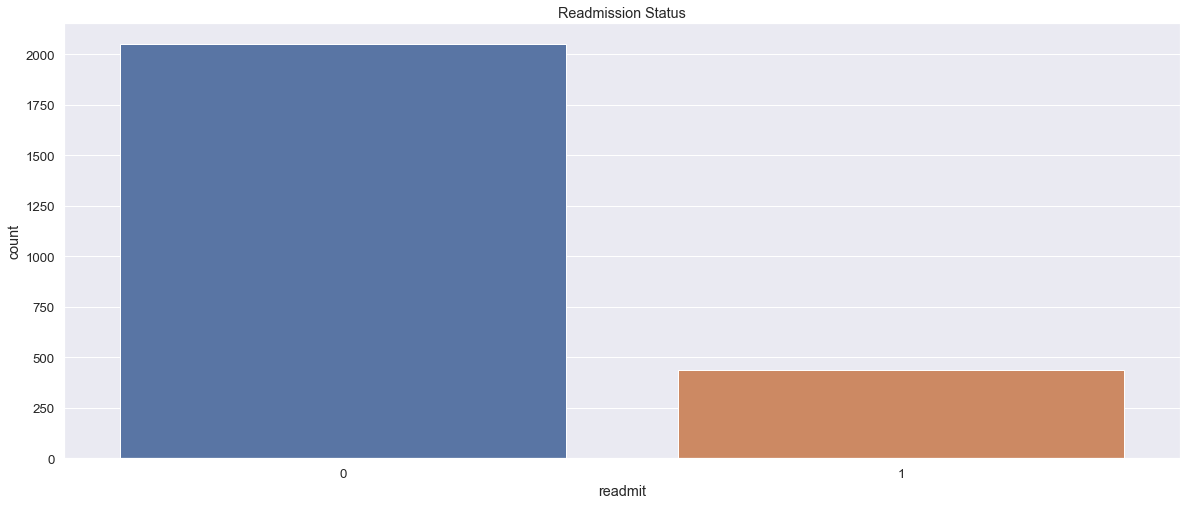

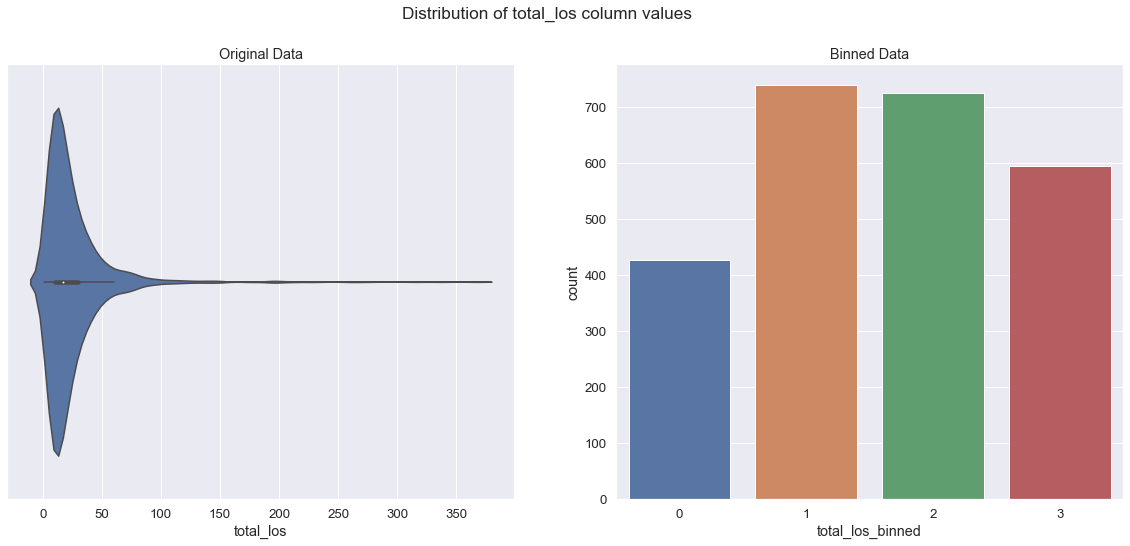

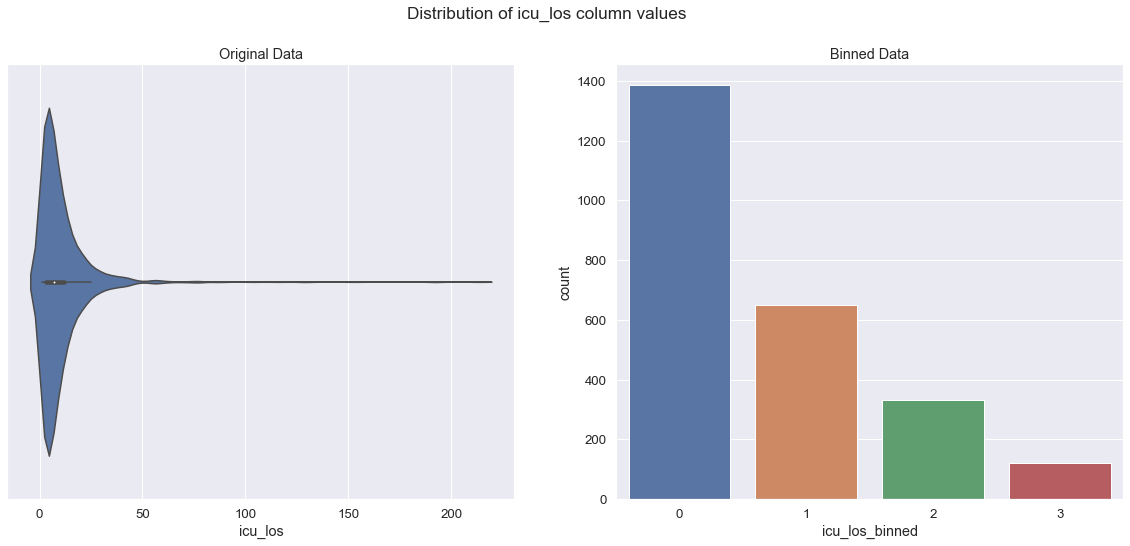

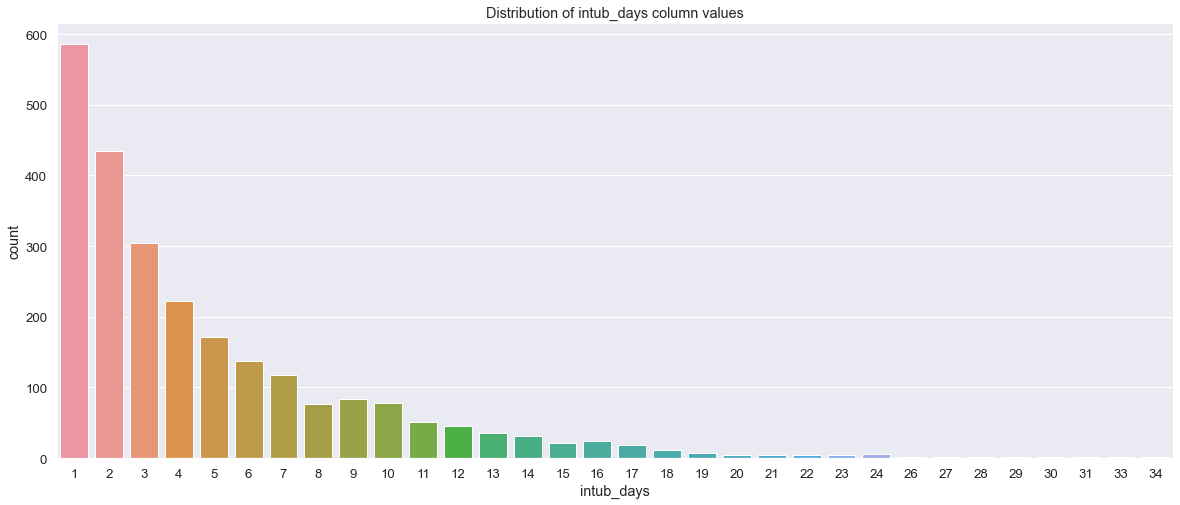

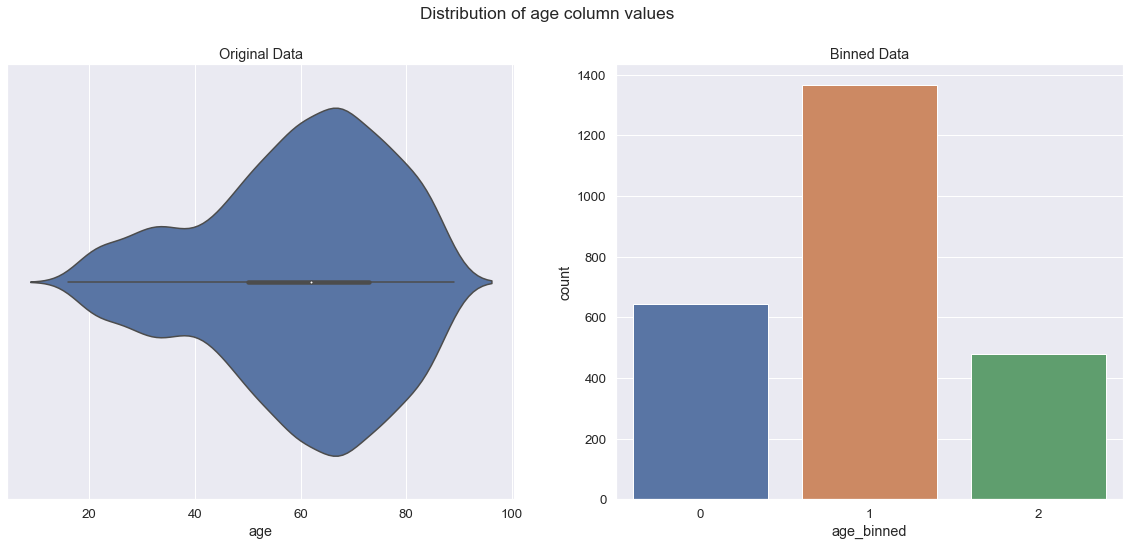

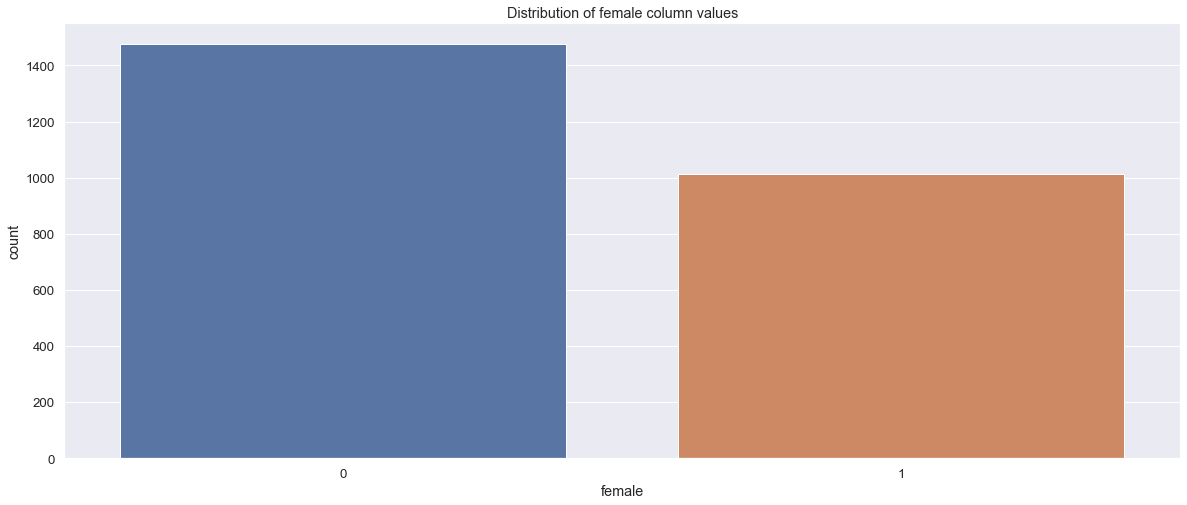

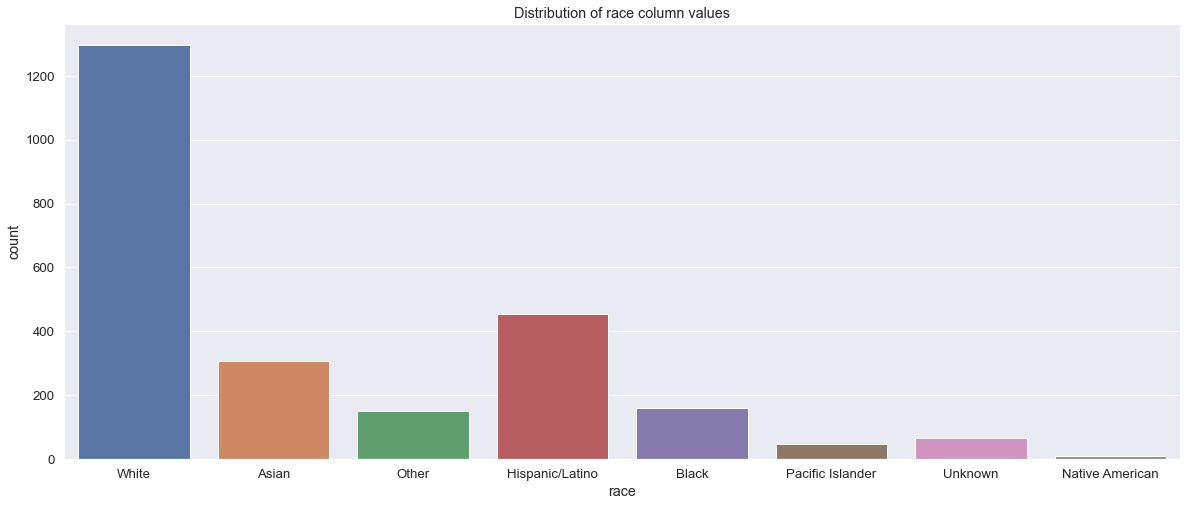

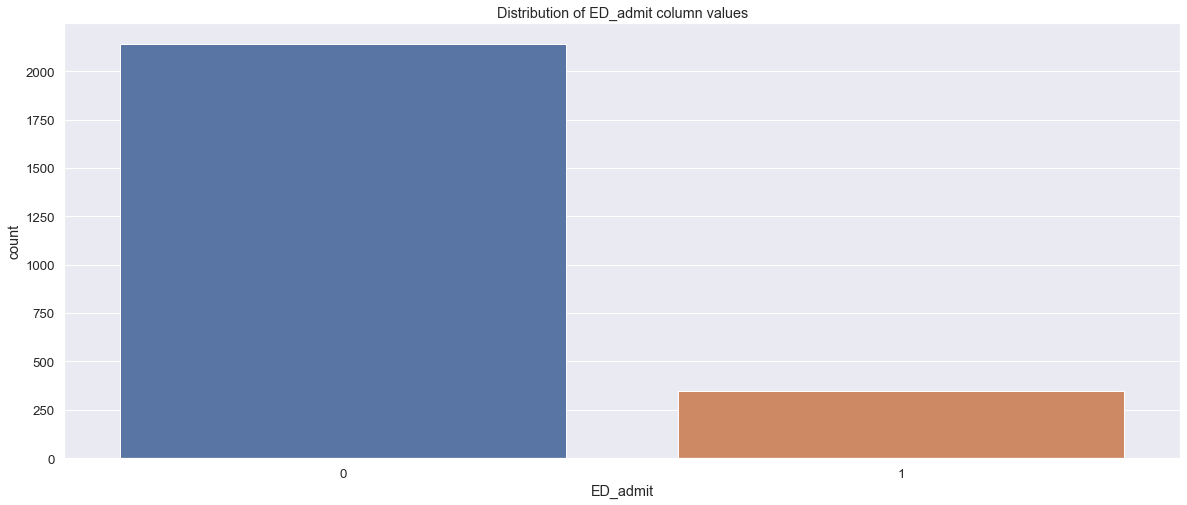

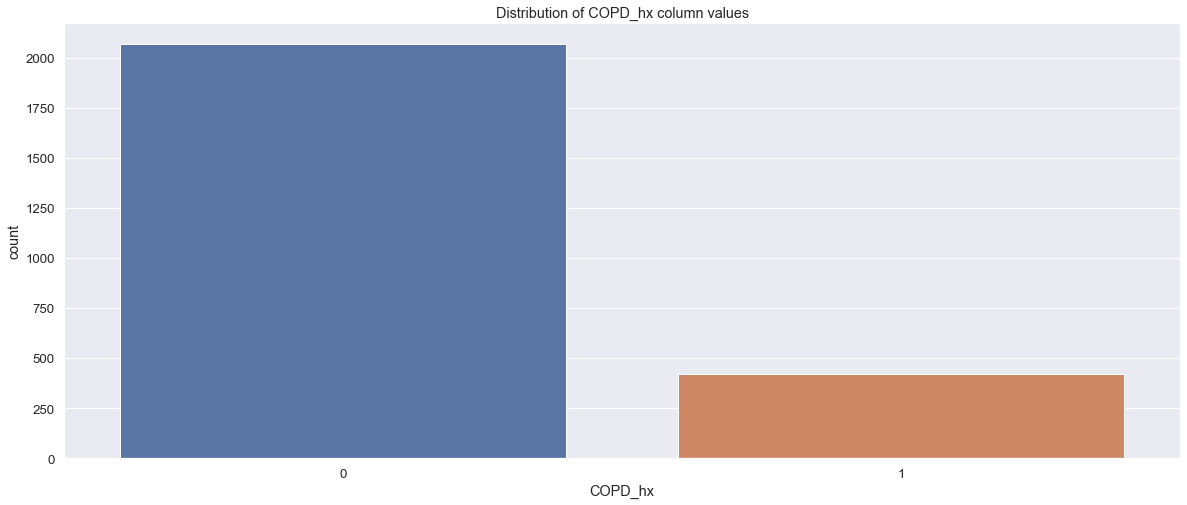

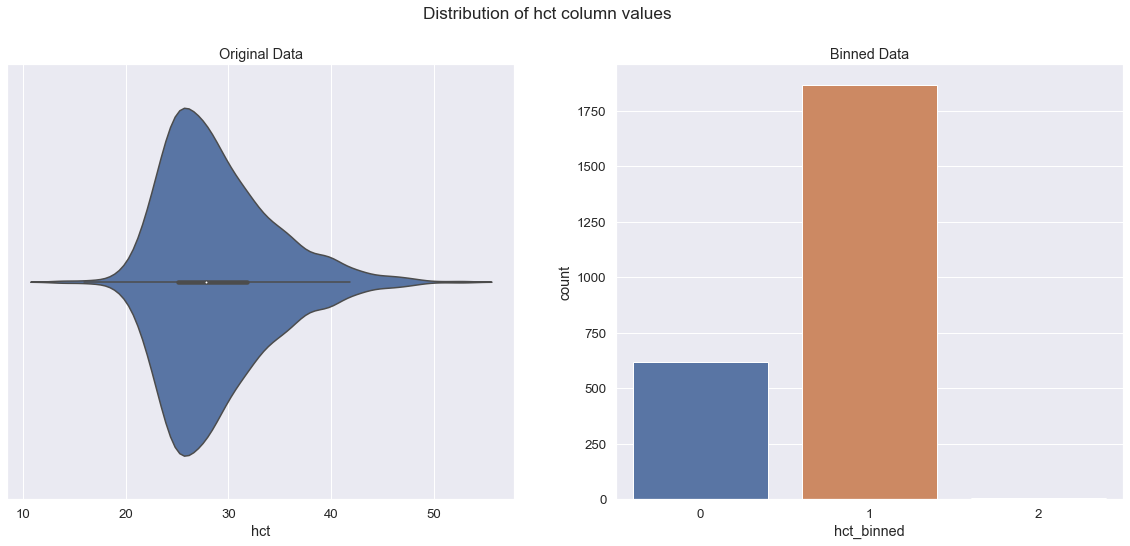

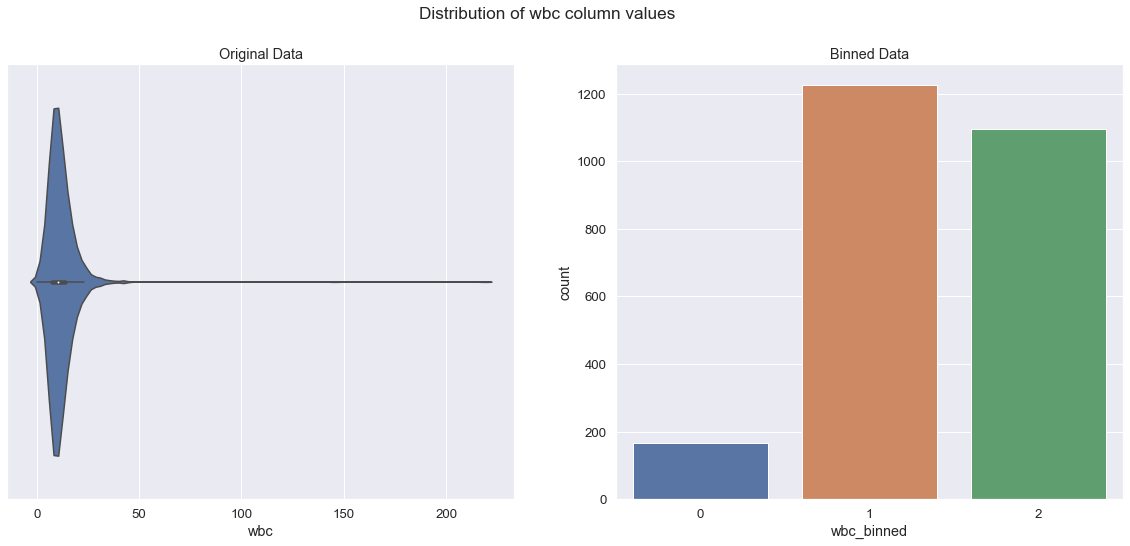

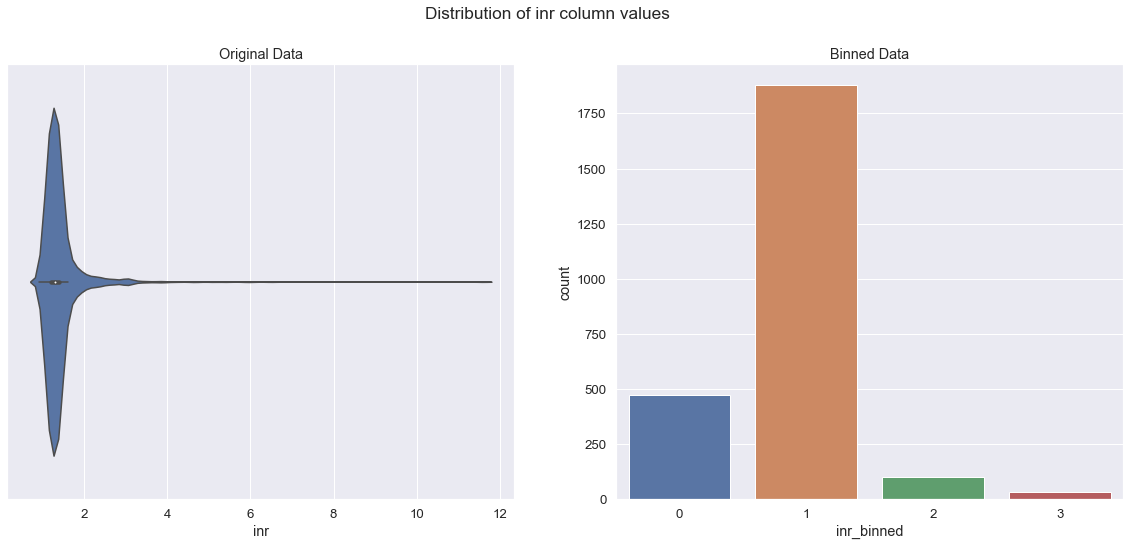

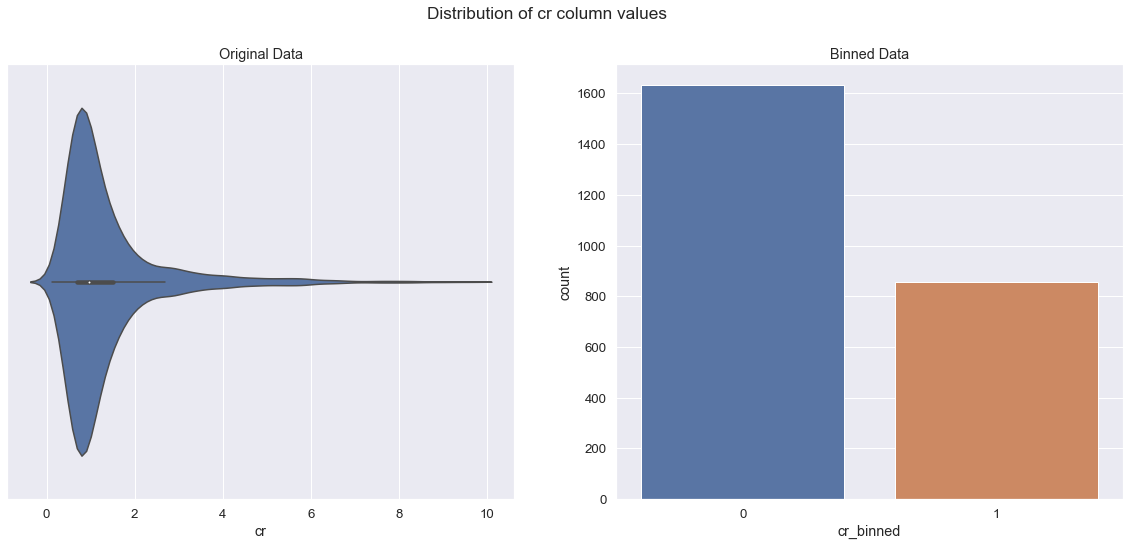

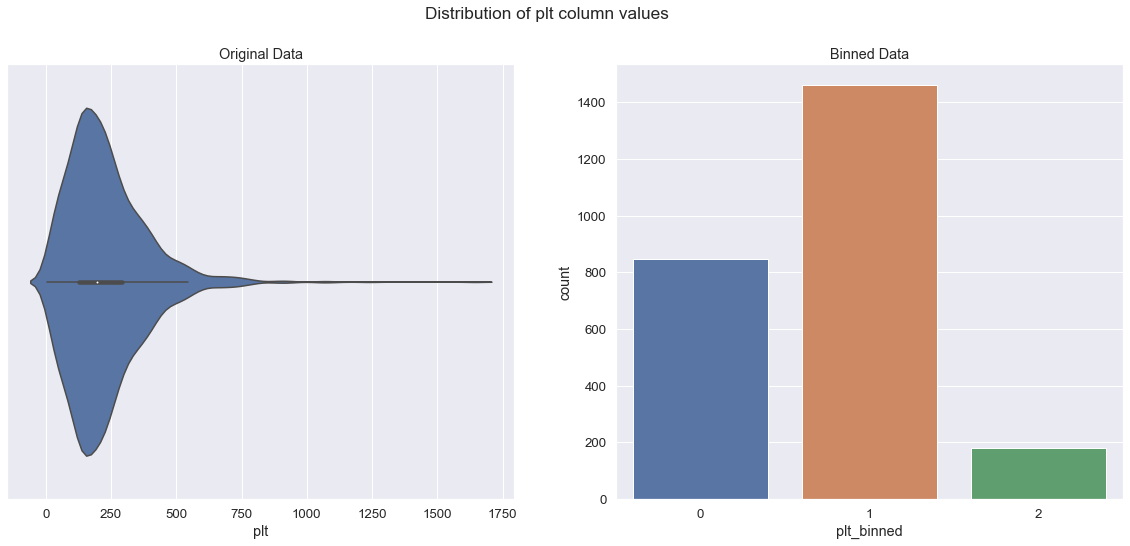

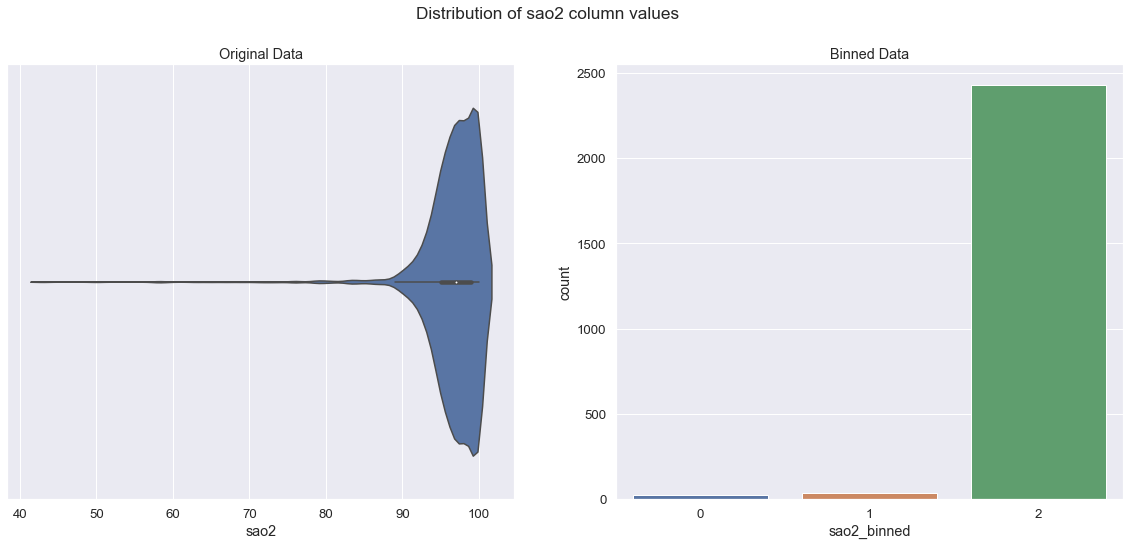

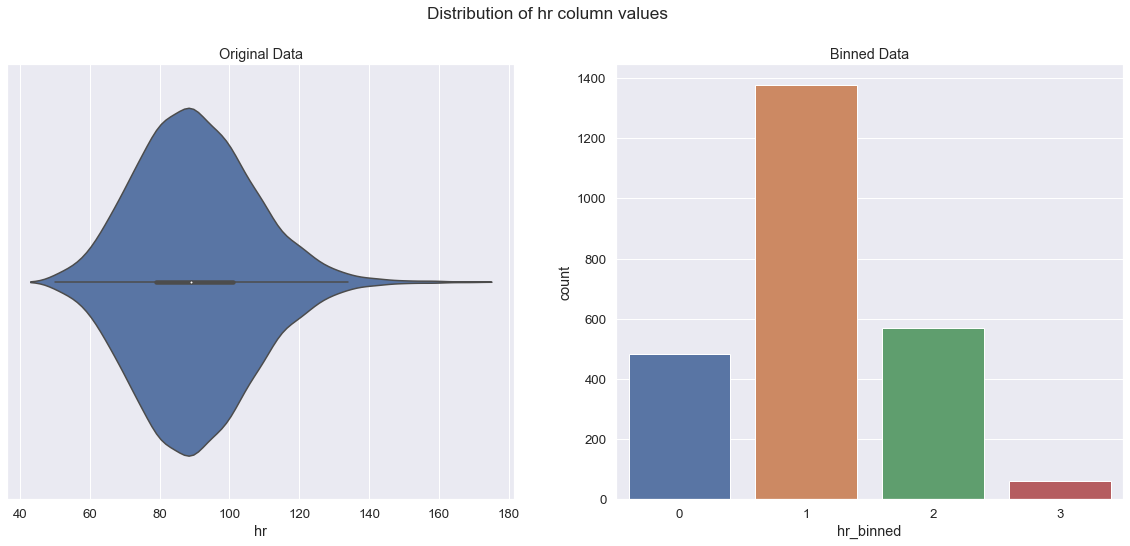

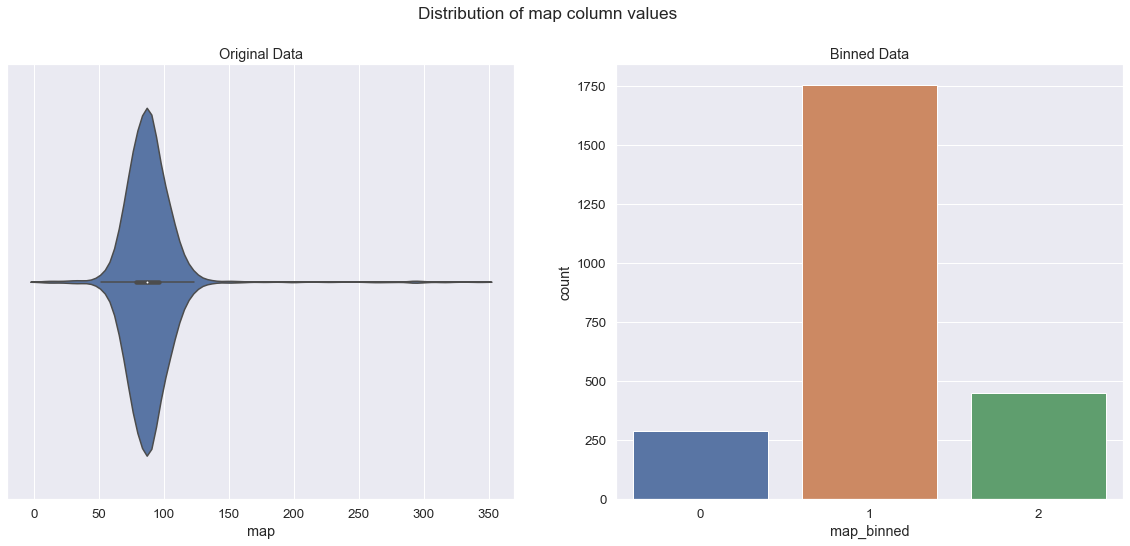

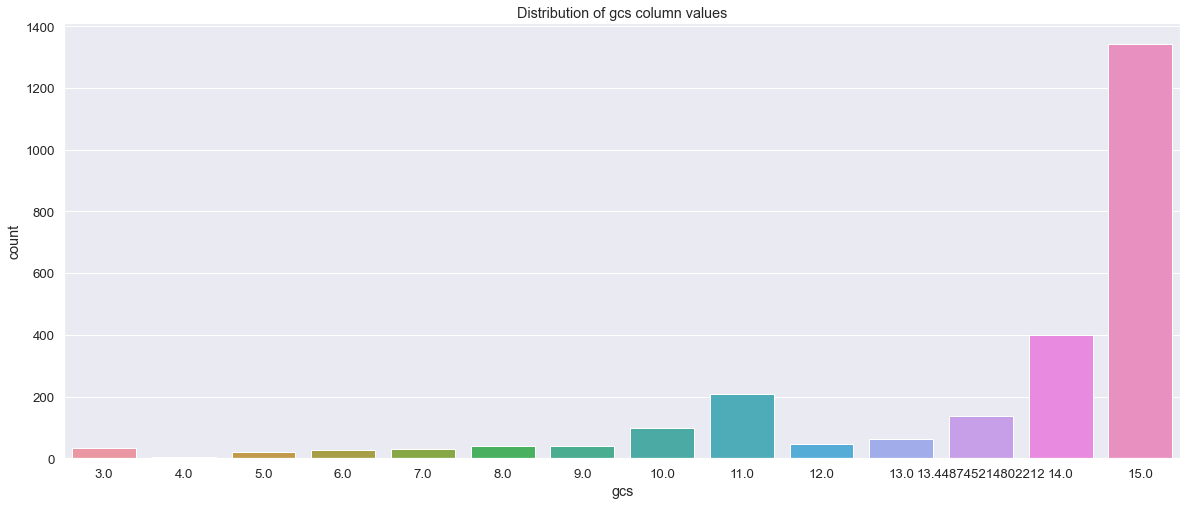

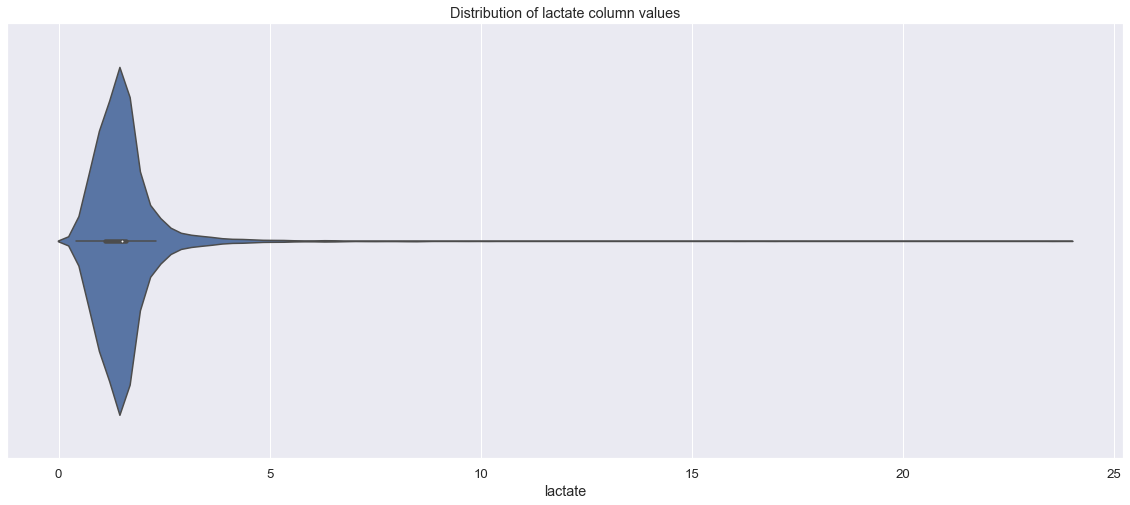

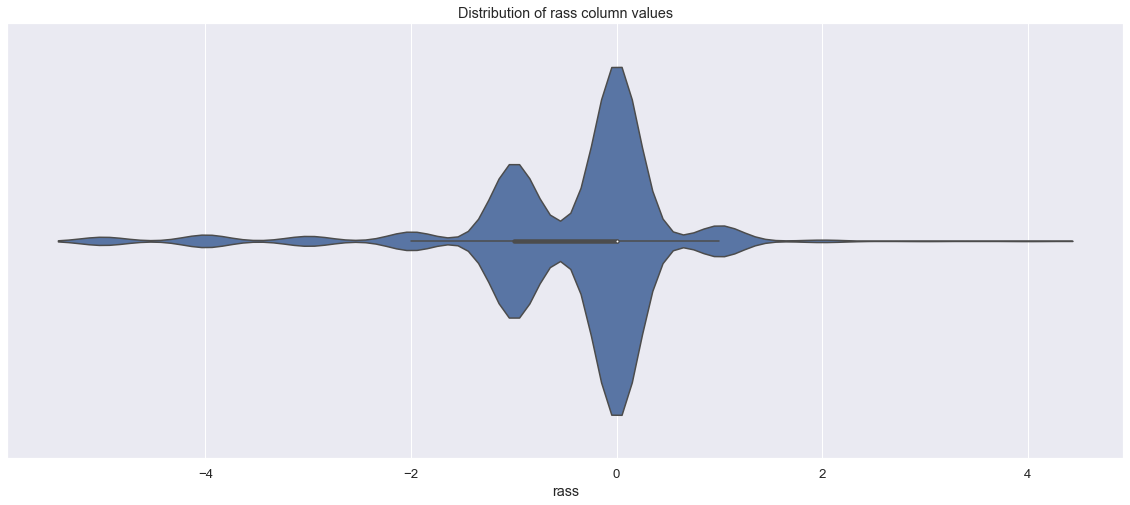

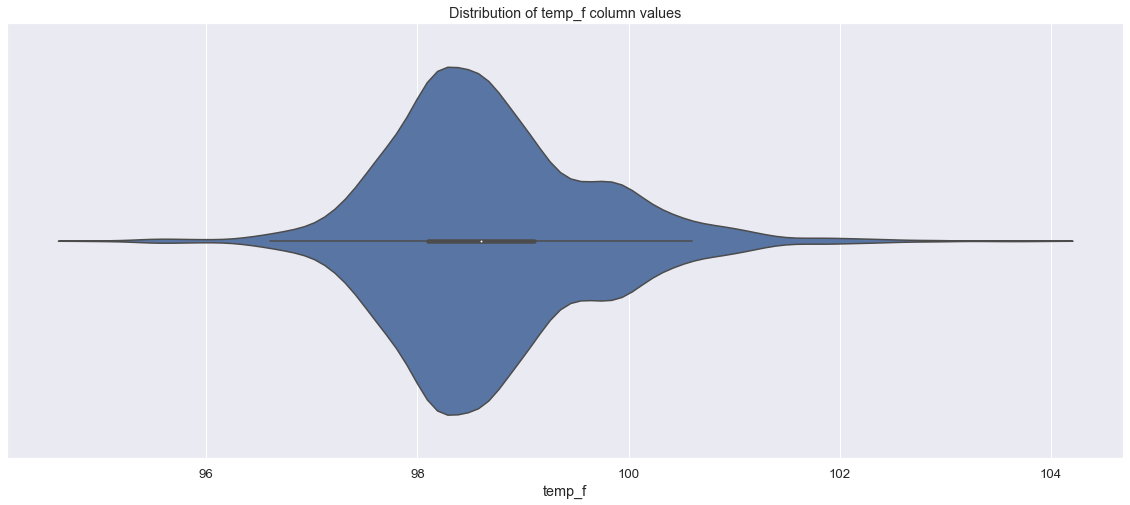

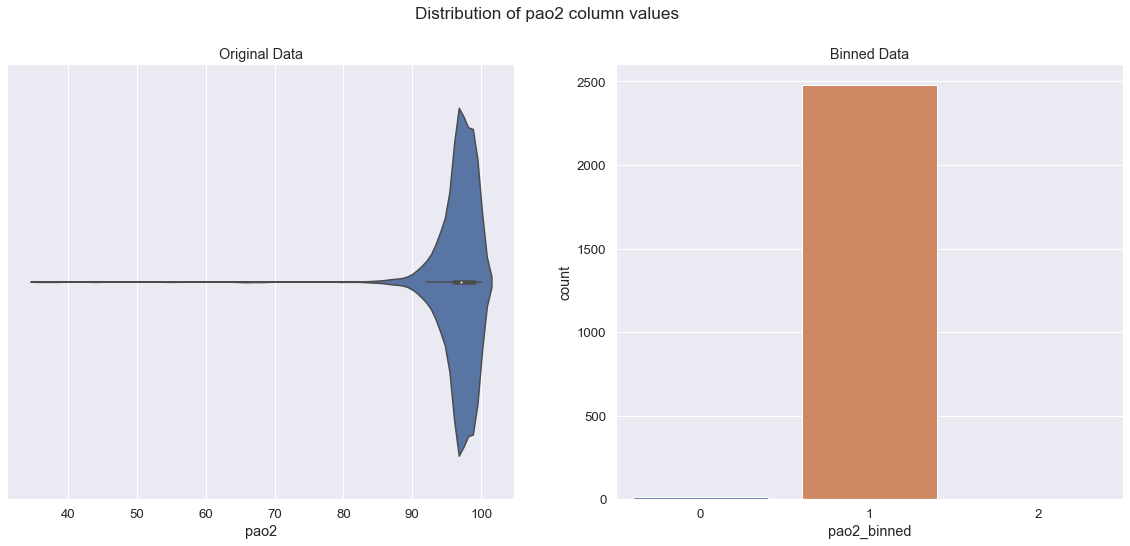

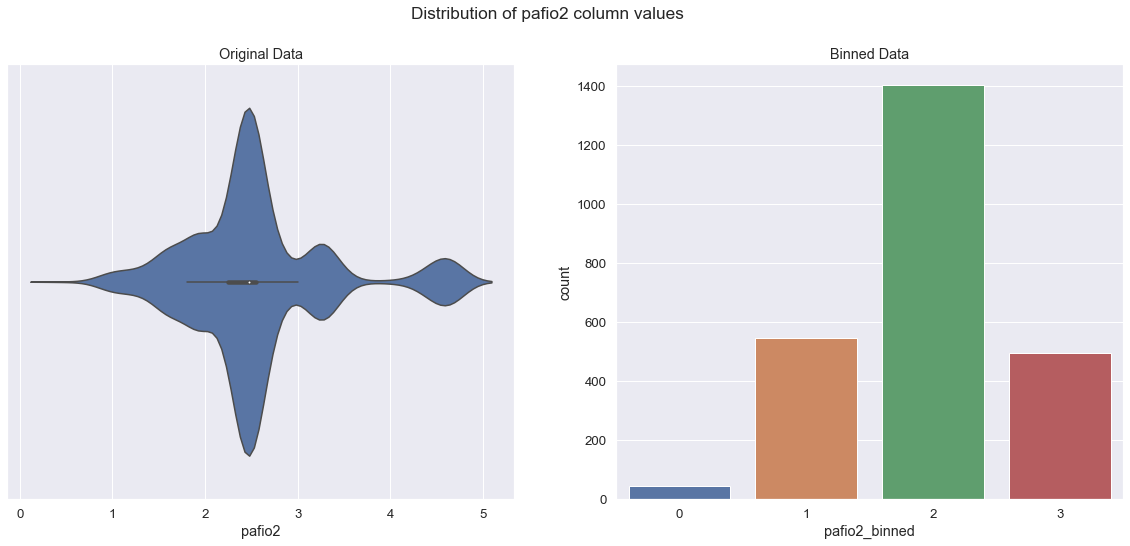

In [19]:
plot_feature_distributions(plot_type, starr_data)

# Mode development

## Create train-test splits

In [20]:
test_proportion = 0.2
# val_proportion is in relation to the train set
# that is 1.0 is the entire train set, not the entire data set
val_proportion = 0.25

# to make sure features from MIMIC and STARR dataframes are in the same order
feature_order = ["intub_days", "female", "ED_admit", "COPD_hx", "gcs", "lactate", "rass", 
                 "temp_f", "total_los_binned", "icu_los_binned", "age_binned", 
                 "hct_binned", "wbc_binned", "inr_binned", "cr_binned", "pafio2_binned", 
                 "pao2_binned", "plt_binned", "sao2_binned", "hr_binned", "map_binned",
                 "race_numeric"]

X = starr_data.drop(columns=["id", "readmit"]+cols_binned+cols_numeric).astype("float")
X = X[feature_order]
y = starr_data[["readmit"]]

# split into train+val and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_proportion, random_state=seed)

# split into train and val 
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=val_proportion, random_state=seed)

## Choose model type with K-fold cross validation (K=5)

Models tested: 

+ Logistic Regression
+ Support Vector Machines
+ Random Forests
+ Gradient Boosting

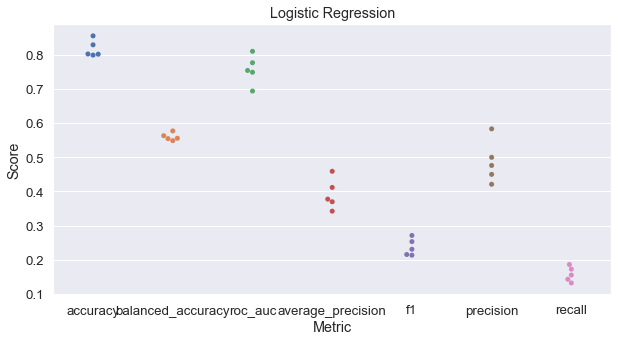

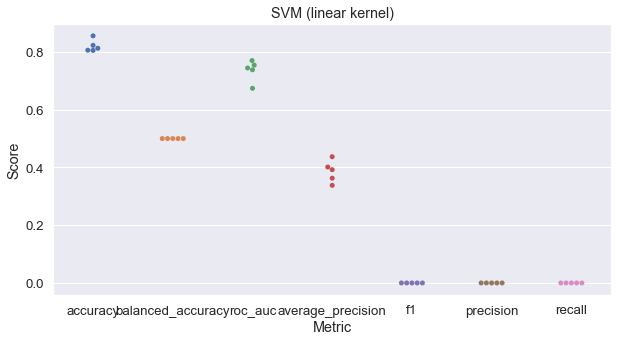

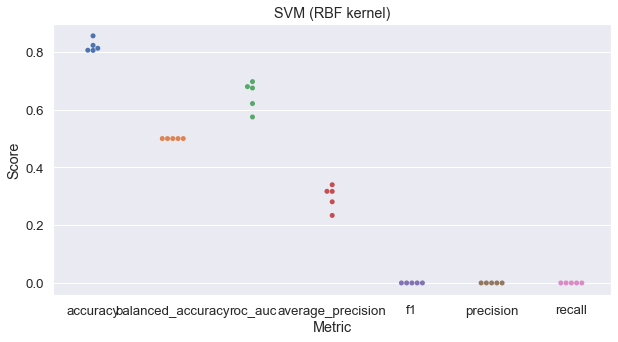

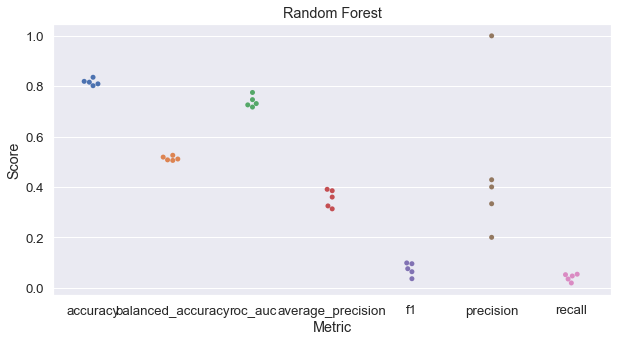

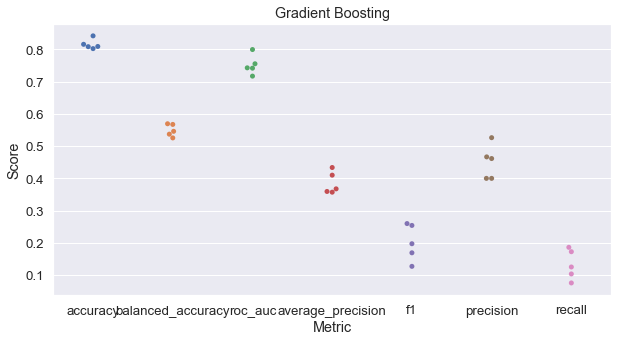

In [21]:
k = 5
# types of scoring paramters 
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
metric = ["accuracy", "balanced_accuracy", "roc_auc", "average_precision", "f1", "precision", "recall"]

models = [("Logistic Regression", LogisticRegression()),
          ("SVM (linear kernel)", SVC(kernel="linear")),
          ("SVM (RBF kernel)", SVC()),
          ("Random Forest",  RandomForestClassifier()),
          ("Gradient Boosting", GradientBoostingClassifier())]
results = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=k, shuffle=True, random_state=seed)
    scores = model_selection.cross_validate(model, X_train, y_train, scoring=metric, cv=kfold)
    results.append((name, scores))

fig_size = (10, 5)
for name, scores in results:
    scores_df = pd.DataFrame.from_dict(scores).drop(columns=["fit_time", "score_time"])
    scores_df.columns = [col[5:] for col in scores_df.columns]
    scores_df = pd.melt(scores_df, var_name="Metric", value_name="Score")
    plt.figure(figsize=fig_size)
    ax = sns.swarmplot(data=scores_df, x="Metric", y="Score")
    ax.set_title(name)
    plt.show()
    print("\n\n")

In [22]:
results

[('Logistic Regression',
  {'fit_time': array([0.05416083, 0.03972101, 0.03174877, 0.02969193, 0.03007793]),
   'score_time': array([0.02228308, 0.00959587, 0.00945783, 0.00912905, 0.00927806]),
   'test_accuracy': array([0.82943144, 0.7993311 , 0.80267559, 0.80201342, 0.8557047 ]),
   'test_balanced_accuracy': array([0.55587513, 0.55476463, 0.54879483, 0.56329023, 0.57733698]),
   'test_roc_auc': array([0.81047707, 0.69409071, 0.75433568, 0.74920977, 0.77692658]),
   'test_average_precision': array([0.45907145, 0.34232703, 0.36989476, 0.41180283, 0.37759156]),
   'test_f1': array([0.21538462, 0.23076923, 0.21333333, 0.25316456, 0.27118644]),
   'test_precision': array([0.58333333, 0.45      , 0.42105263, 0.47619048, 0.5       ]),
   'test_recall': array([0.13207547, 0.15517241, 0.14285714, 0.17241379, 0.18604651])}),
 ('SVM (linear kernel)',
  {'fit_time': array([0.88671517, 0.73368001, 0.84220314, 0.69983697, 0.76682115]),
   'score_time': array([0.02036095, 0.01674008, 0.01629496, 0

We prefer a model with high sensitivity (recall) and high PPV (precision). The F1-score encapsulates both, so we will use it when choosing models. Based on this measurements, it seems that either a **Logistic Regression** or **Gradient Boosting** model are the most promising choice. 

## Tune hyperparameters

### Logistic Regression Classifier

In [23]:
metric = ["accuracy", "balanced_accuracy", "roc_auc", "average_precision", "f1", "precision", "recall"]
def validation_results(clf, X_val, y_val, name, results):
    y_pred = clf.predict(X_val)
    if "SVM" in name:
        y_score = clf.decision_function(X_val)
    else:
        y_score = clf.predict_proba(X_val)[:, 1]
    
    acc = metrics.accuracy_score(y_val, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_val, y_pred)
    roc_auc = metrics.roc_auc_score(y_val, y_score)
    avg_prec = metrics.average_precision_score(y_val, y_score)
    f1 = metrics.f1_score(y_val, y_pred)
    precision = metrics.precision_score(y_val, y_pred)
    recall = metrics.recall_score(y_val, y_pred)     
    results[name] = {"accuracy": acc,
                     "balanced_accuracy": bal_acc,
                     "roc_auc": roc_auc,
                     "average_precision": avg_prec,
                     "f1": f1,
                     "precision": precision,
                     "recall": recall}
    
    return results

In [24]:
solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
penalties = ["l1", "l2"]
C_values = [100, 10, 1.0, 0.1, 0.01] # smaller values = stronger regularization

i = 0
results = {}
models = []
for solver, penalty, C in it.product(solvers, penalties, C_values):
    if solver in ["newton-cg", "sag", "lbfgs"] and penalty != "l2":
        # skip parameter configurations not supported by scikit-learn
        continue
        
    print("Model #{i} Hyperparameters => Solver: {s}, Penalty: {p}, C: {c}".format(i=i, s=solver, p=penalty, c=C))
    if solver in ["sag", "saga", "liblinear"]:
        # these solvers first shuffle the data, so include random seed
        model = LogisticRegression(solver=solver, penalty=penalty, C=C, random_state=seed)
    else:
        model = LogisticRegression(solver=solver, penalty=penalty, C=C)
    model.fit(X_train, y_train)
    models.append(model)
    results = validation_results(model, X_val, y_val, "Model #%d" % i, results)
    i += 1

Model #0 Hyperparameters => Solver: newton-cg, Penalty: l2, C: 100
Model #1 Hyperparameters => Solver: newton-cg, Penalty: l2, C: 10
Model #2 Hyperparameters => Solver: newton-cg, Penalty: l2, C: 1.0
Model #3 Hyperparameters => Solver: newton-cg, Penalty: l2, C: 0.1
Model #4 Hyperparameters => Solver: newton-cg, Penalty: l2, C: 0.01
Model #5 Hyperparameters => Solver: lbfgs, Penalty: l2, C: 100
Model #6 Hyperparameters => Solver: lbfgs, Penalty: l2, C: 10
Model #7 Hyperparameters => Solver: lbfgs, Penalty: l2, C: 1.0
Model #8 Hyperparameters => Solver: lbfgs, Penalty: l2, C: 0.1
Model #9 Hyperparameters => Solver: lbfgs, Penalty: l2, C: 0.01
Model #10 Hyperparameters => Solver: liblinear, Penalty: l1, C: 100
Model #11 Hyperparameters => Solver: liblinear, Penalty: l1, C: 10
Model #12 Hyperparameters => Solver: liblinear, Penalty: l1, C: 1.0
Model #13 Hyperparameters => Solver: liblinear, Penalty: l1, C: 0.1
Model #14 Hyperparameters => Solver: liblinear, Penalty: l1, C: 0.01
Model #15 

In [25]:
def plot_validation_results(results, model_name, fig_size=(10, 8)):
    results_df = pd.DataFrame()
    for name, result in results.items():
        results_df = results_df.append(result, ignore_index=True)

    results_df = pd.melt(results_df, var_name="Metric", value_name="Score")
    results_df["Name"] = list(results.keys()) * len(metric)

    ncol = (len(results.keys()) // 20) + 1
    plt.figure(figsize=fig_size)
    ax = sns.swarmplot(data=results_df, x="Metric", y="Score", hue="Name")
    ax.set_title("Performance of %s Models with Varied Hyperparameters" % model_name)
    plt.legend(bbox_to_anchor=(1.5, 1), loc="upper right", ncol=ncol)
    plt.show()
    
    print("\n\n")

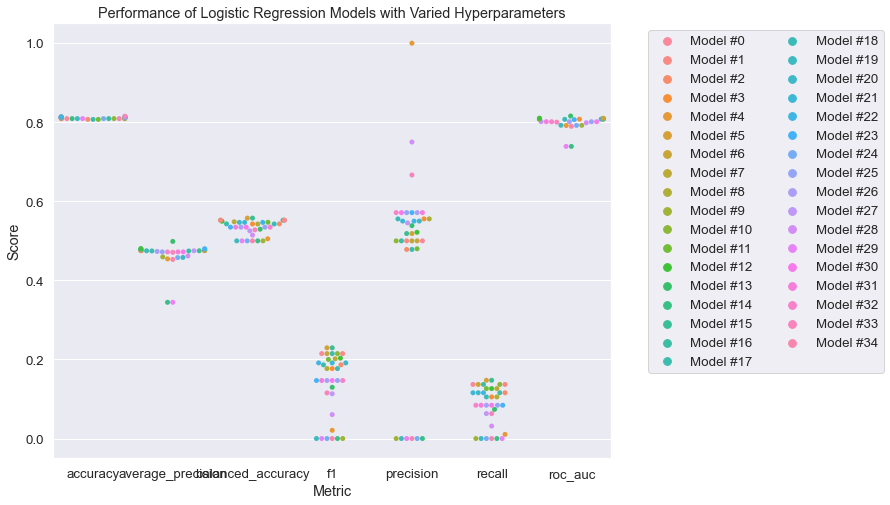

In [26]:
plot_validation_results(results, "Logistic Regression")

#### Explore some values from the results

In [27]:
def filter_validation_results(results, metric_name, threshold):
    filtered_models = []
    for name, result in results.items():
        if result[metric_name] > threshold:
            print(name)
            filtered_models.append(name)
            
    return filtered_models

def find_models(filtered_results):
    for model_name in filtered_results:
        print(model_name)
        print(results[model_name])
        print()

In [28]:
p_6 = filter_validation_results(results, "precision", 0.6)

Model #4
Model #28
Model #33


In [29]:
find_models(p_6)

Model #4
{'accuracy': 0.8112449799196787, 'balanced_accuracy': 0.5052631578947369, 'roc_auc': 0.7917722345566148, 'average_precision': 0.45437904452452804, 'f1': 0.020833333333333332, 'precision': 1.0, 'recall': 0.010526315789473684}

Model #28
{'accuracy': 0.8132530120481928, 'balanced_accuracy': 0.5145487788951286, 'roc_auc': 0.7987201253754734, 'average_precision': 0.46191383109195117, 'f1': 0.06060606060606061, 'precision': 0.75, 'recall': 0.031578947368421054}

Model #33
{'accuracy': 0.8152610441767069, 'balanced_accuracy': 0.5278568630011754, 'roc_auc': 0.8002089591223717, 'average_precision': 0.4710002997447255, 'f1': 0.11538461538461539, 'precision': 0.6666666666666666, 'recall': 0.06315789473684211}



In [30]:
p_5 = filter_validation_results(results, "precision", 0.5)

Model #3
Model #4
Model #5
Model #8
Model #12
Model #13
Model #15
Model #18
Model #20
Model #21
Model #22
Model #23
Model #25
Model #26
Model #27
Model #28
Model #30
Model #31
Model #32
Model #33


In [31]:
r_1 = filter_validation_results(results, "recall", 0.1)

Model #0
Model #1
Model #2
Model #3
Model #5
Model #6
Model #7
Model #8
Model #10
Model #11
Model #12
Model #15
Model #16
Model #17
Model #18
Model #20
Model #21
Model #22


In [32]:
good_models = set(p_5).intersection(set(r_1))
find_models(good_models)

Model #22
{'accuracy': 0.8132530120481928, 'balanced_accuracy': 0.5467284837403683, 'roc_auc': 0.807992686430717, 'average_precision': 0.4790241622364635, 'f1': 0.19130434782608693, 'precision': 0.55, 'recall': 0.11578947368421053}

Model #20
{'accuracy': 0.8132530120481928, 'balanced_accuracy': 0.5467284837403683, 'roc_auc': 0.8082538853336815, 'average_precision': 0.47933941252477735, 'f1': 0.19130434782608693, 'precision': 0.55, 'recall': 0.11578947368421053}

Model #12
{'accuracy': 0.8112449799196787, 'balanced_accuracy': 0.5495102520569414, 'roc_auc': 0.8102912367768056, 'average_precision': 0.48040209346910046, 'f1': 0.20338983050847456, 'precision': 0.5217391304347826, 'recall': 0.12631578947368421}

Model #8
{'accuracy': 0.8132530120481928, 'balanced_accuracy': 0.5427060206347134, 'roc_auc': 0.8085412041269426, 'average_precision': 0.47588111630451874, 'f1': 0.17699115044247787, 'precision': 0.5555555555555556, 'recall': 0.10526315789473684}

Model #18
{'accuracy': 0.8132530120

In [33]:
f1_2 = filter_validation_results(results, "f1", 0.2)

Model #0
Model #1
Model #5
Model #6
Model #7
Model #10
Model #12
Model #15
Model #16


In [34]:
find_models(f1_2)

Model #0
{'accuracy': 0.8092369477911646, 'balanced_accuracy': 0.5522920203735144, 'roc_auc': 0.8086195637978321, 'average_precision': 0.4753405970349017, 'f1': 0.21487603305785127, 'precision': 0.5, 'recall': 0.1368421052631579}

Model #1
{'accuracy': 0.8092369477911646, 'balanced_accuracy': 0.5522920203735144, 'roc_auc': 0.8085150842366462, 'average_precision': 0.4752331615466253, 'f1': 0.21487603305785127, 'precision': 0.5, 'recall': 0.1368421052631579}

Model #5
{'accuracy': 0.8112449799196787, 'balanced_accuracy': 0.5575551782682513, 'roc_auc': 0.8080971659919027, 'average_precision': 0.4766316249695384, 'f1': 0.22950819672131142, 'precision': 0.5185185185185185, 'recall': 0.14736842105263157}

Model #6
{'accuracy': 0.8092369477911646, 'balanced_accuracy': 0.5522920203735144, 'roc_auc': 0.810082277654434, 'average_precision': 0.47730168509462295, 'f1': 0.21487603305785127, 'precision': 0.5, 'recall': 0.1368421052631579}

Model #7
{'accuracy': 0.8092369477911646, 'balanced_accuracy

#### Find best model and plot its ROC and PR Curves

In [35]:
def plot_roc_pr_curves(X, y, clf, fig_size=(10, 8)):
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    roc_disp = metrics.plot_roc_curve(clf, X, y, ax=ax)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic (ROC) Curve")
    plt.show()

    # PR Curve and AP (average precision)
    fig, ax = plt.subplots(1,1,figsize=fig_size)
    pr_disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall (PR) Curve")
    plt.show()

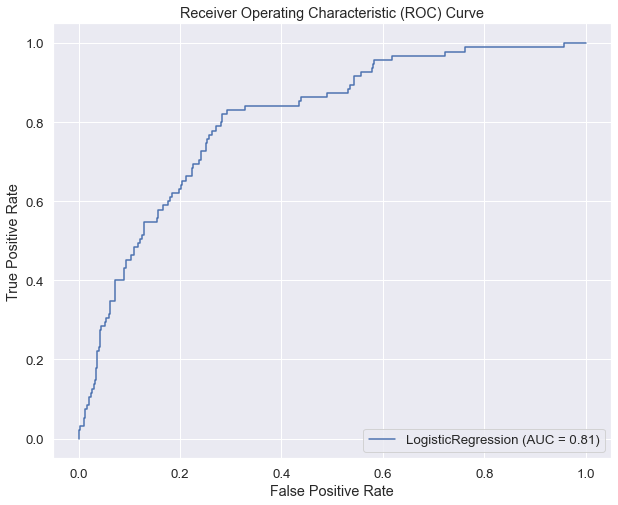

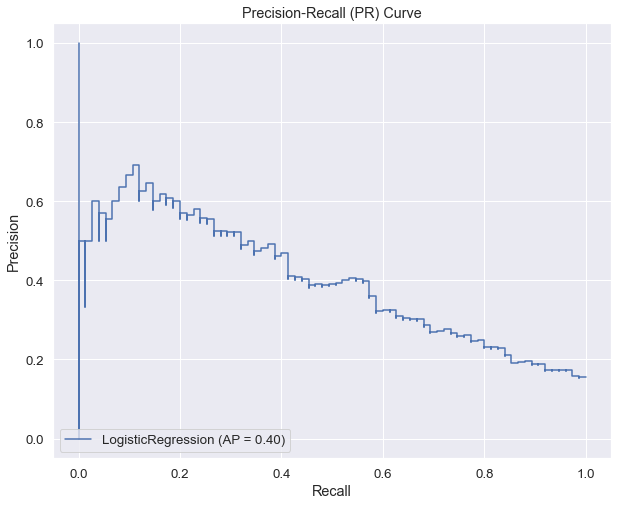

In [36]:
best_model_num = 5
lr_best_model = models[best_model_num]
plot_roc_pr_curves(X_val, y_val, lr_best_model)

### Ensemble-based models: Gradient Boosting and Random Forest

In [37]:
ensemble_results = {}
ensemble_models = {}

### Gradient Boosting Classifier

**Baseline scikit-learn settings**  
n_estimators = 100 (number of trees)  
max_depth = 3  
min_samples_split = 2  
min_samples_leaf = 1  
subsample = 1.0  

learning_rate = 0.1 (shrinkage)  
subsample = 1

In [38]:
# Baseline model
gb_baseline = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 3, min_samples_split = 2, 
                                     min_samples_leaf = 1, subsample = 1, max_features = "sqrt", random_state = seed)
gb_baseline.fit(X_train, y_train)

ensemble_results = validation_results(gb_baseline, X_val, y_val, "GB baseline", ensemble_results)
ensemble_models["GB baseline"] = gb_baseline

In [39]:
param_1 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1]}
param_2 = {'learning_rate':  [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750]}
param_3 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750], 'max_depth': [2, 3, 4]}
param_4 = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, .25, .5, .75, 1], 
              'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500, 1750], 
             'max_depth': [2, 3, 4], 
             'max_features': [3, 4, 5]}

In [40]:
# GBM with param_1
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                                             n_estimators = 100,
                                                             max_depth = 3, min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_1, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.1235744 , 0.10365481, 0.10103078, 0.09151497, 0.08442097,
         0.08433599, 0.08371048, 0.08628173, 0.08357916, 0.08336082]),
  'std_fit_time': array([0.00868311, 0.00172097, 0.00191972, 0.00642868, 0.00053948,
         0.0014062 , 0.00090933, 0.00117218, 0.00083063, 0.00263607]),
  'mean_score_time': array([0.00358906, 0.00367346, 0.00349865, 0.00302038, 0.00289421,
         0.0025949 , 0.00273805, 0.00273848, 0.00307136, 0.00277405]),
  'std_score_time': array([0.00050295, 0.00052658, 0.0001705 , 0.00022393, 0.00016929,
         0.00011508, 0.00028713, 0.00029703, 0.00056632, 0.00025752]),
  'param_learning_rate': masked_array(data=[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75,
                     1],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.001},
   {'learning_rate': 0.005},
   {'learnin

In [41]:
# GBM with param_2
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                             max_depth = 3, min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_2, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.09756637, 0.22168984, 0.4243578 , 0.71220751, 1.00746598,
         1.33315463, 1.52443137, 1.74611039, 0.10190563, 0.2611052 ,
         0.48711352, 0.72296948, 0.96985426, 1.18909292, 1.40705562,
         1.66612463, 0.1010766 , 0.24373245, 0.49028292, 0.72503262,
         1.09540024, 1.27311745, 1.5088387 , 1.80094256, 0.11220889,
         0.28940668, 0.56187854, 0.85343513, 1.22317953, 1.41651821,
         1.54772043, 1.79383402, 0.11047626, 0.26342969, 0.58436556,
         0.92406421, 1.28955407, 1.58417397, 1.84067063, 1.86569672,
         0.10874333, 0.2665803 , 0.53102689, 0.91867762, 1.22877092,
         1.59289727, 2.11152434, 2.41871209, 0.12705541, 0.2895978 ,
         0.70066881, 1.04860573, 1.3510932 , 1.41213531, 2.04080181,
         2.58229556, 0.16046567, 0.42494121, 0.80268326, 1.23819051,
         1.54828005, 1.74605074, 2.01535101, 2.39930525, 0.14034543,
         0.32874718, 0.6219173 , 0.92554383, 1.16811719, 1.50077019,
         1.823799

In [42]:
# GBM with param_3
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, max_features= 'sqrt',
                                                             min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_3, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.0897193 , 0.2524662 , 0.47171865, 0.6510005 , 0.88799119,
         1.08727422, 1.31160688, 1.59473834, 0.14736118, 0.27355208,
         0.54264178, 0.82624197, 1.1522963 , 1.49077859, 1.83527312,
         2.0812252 , 0.18081532, 0.44834075, 0.82668695, 1.21769686,
         1.52156286, 2.0063838 , 2.56743298, 2.83902946, 0.08731856,
         0.28155789, 0.47070222, 0.65456452, 0.92232127, 1.10810823,
         1.30180659, 1.55044265, 0.1190927 , 0.30222802, 0.57978663,
         0.96001921, 1.16607742, 1.37260532, 1.6871954 , 2.02186399,
         0.16597548, 0.38812361, 0.7946291 , 1.20370741, 1.50140958,
         1.98851523, 2.4688611 , 2.89193401, 0.09510756, 0.28048358,
         0.45565858, 0.64540224, 0.85563459, 1.07553277, 1.24592867,
         1.49457951, 0.11675649, 0.27912993, 0.53451438, 0.82968402,
         1.10796413, 1.39698958, 1.63383713, 2.23952074, 0.18647685,
         0.39230933, 0.803719  , 1.14977641, 1.65387688, 1.97349973,
         2.315223

In [43]:
# GBM with param_4
tuning = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(subsample = 1, 
                                                             min_samples_split = 2, min_samples_leaf = 1,
                                                             random_state = seed), 
                     param_grid = param_4, scoring = 'accuracy', n_jobs = 4, cv = 5)
tuning.fit(X_train, y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

({'mean_fit_time': array([0.0824934 , 0.16533327, 0.33286424, 0.49651103, 0.7082696 ,
         0.92400222, 1.39163723, 1.78094859, 0.09447904, 0.28216286,
         0.51712046, 0.94474955, 1.13589425, 1.24936395, 1.94429698,
         2.23704758, 0.11357274, 0.2773592 , 0.51766777, 0.74247875,
         0.91137333, 1.08734956, 1.33526635, 1.63940544, 0.16023512,
         0.3974154 , 0.6342402 , 0.75142632, 1.14772539, 1.96861501,
         2.14382291, 2.77465224, 0.17760081, 0.34534631, 0.82045741,
         0.9834372 , 1.31863923, 1.7350522 , 2.09213085, 2.34410143,
         0.13707981, 0.32037973, 0.63942876, 0.97369342, 1.42064705,
         1.6753448 , 2.00186095, 2.32649393, 0.16815672, 0.41777225,
         0.82216873, 1.29958982, 1.76447897, 2.41356363, 2.41999478,
         2.9275773 , 0.2381968 , 0.39137111, 0.93022084, 1.4322794 ,
         1.61666489, 2.26483188, 3.8984992 , 4.65557418, 0.34315844,
         0.62913938, 1.41904721, 1.49092293, 2.23878756, 2.49018631,
         2.471332

In [44]:
gb_model_param1 = GradientBoostingClassifier(learning_rate = 0.001, random_state = seed)
gb_model_param1.fit(X_train, y_train)
predictions = gb_model_param1.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       403
           1       0.00      0.00      0.00        95

    accuracy                           0.81       498
   macro avg       0.40      0.50      0.45       498
weighted avg       0.65      0.81      0.72       498



In [45]:
gb_model_param2 = GradientBoostingClassifier(learning_rate = 0.005,n_estimators = 500, random_state = seed)
gb_model_param2.fit(X_train, y_train)
predictions = gb_model_param2.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       403
           1       1.00      0.05      0.10        95

    accuracy                           0.82       498
   macro avg       0.91      0.53      0.50       498
weighted avg       0.85      0.82      0.75       498



In [46]:
gb_model_param3 = GradientBoostingClassifier(learning_rate = 0.001, n_estimators = 1500, max_depth = 4, random_state = seed)
gb_model_param3.fit(X_train, y_train)
predictions = gb_model_param3.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       403
           1       0.50      0.03      0.06        95

    accuracy                           0.81       498
   macro avg       0.66      0.51      0.48       498
weighted avg       0.75      0.81      0.73       498



In [47]:
gb_model_param4 = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 3, max_features = 5,
                                             n_estimators = 250, random_state = seed)
gb_model_param4.fit(X_train, y_train)
predictions = gb_model_param4.predict(X_val)
print(metrics.classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       403
           1       0.00      0.00      0.00        95

    accuracy                           0.81       498
   macro avg       0.40      0.50      0.45       498
weighted avg       0.65      0.81      0.72       498



In [48]:
gb_best_model = gb_model_param2
ensemble_models["GB best model"] = gb_best_model

### Random Forest Classifier

In [49]:
rf = RandomForestClassifier(random_state = seed)

# Look at parameters in rf 
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 212,
 'verbose': 0,
 'warm_start': False}


In [50]:
rf_baseline = RandomForestClassifier(random_state = seed)
rf_baseline.fit(X_train, y_train)

ensemble_results = validation_results(rf_baseline, X_val, y_val, "RF baseline", ensemble_results)
ensemble_models["RF baseline"] = rf_baseline

In [51]:
# Random search grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree 
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node 
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [52]:
# Create random grid
random_grid = {'n_estimators': n_estimators, 
              'max_features': max_features, 
              'max_depth': max_depth, 
              'min_samples_split': min_samples_split, 
              'min_samples_leaf': min_samples_leaf, 
              'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [53]:
# Random search training
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation
# Search across 100 different combinations, and use all available cores
rf_random = model_selection.RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state = seed, 
                              n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random_model = rf_random.best_estimator_

ensemble_results = validation_results(rf_random_model, X_val, y_val, "RF best model (Random Search)", ensemble_results)
ensemble_models["RF best model (Random Search)"] = rf_random_model

# View best parameters
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [54]:
param_grid = {
    'bootstrap':[True],
    'max_depth': [9, 10, 11], 
    'max_features': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [1, 2, 3, 4], 
    'n_estimators': [400, 500, 600, 700, 800, 900]
}

In [55]:
# Create a base model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = model_selection.GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [56]:
# Fit grid to search data
grid_search.fit(X_train, y_train)

# Best model
rf_grid_model = grid_search.best_estimator_

ensemble_results = validation_results(rf_grid_model, X_val, y_val, "RF best model (Grid Search)", ensemble_results)
ensemble_models["Rf best model (Grid Search)"] = rf_grid_model

grid_search.best_params_

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


{'bootstrap': True,
 'max_depth': 9,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 400}

#### Visualize model performance on validation set

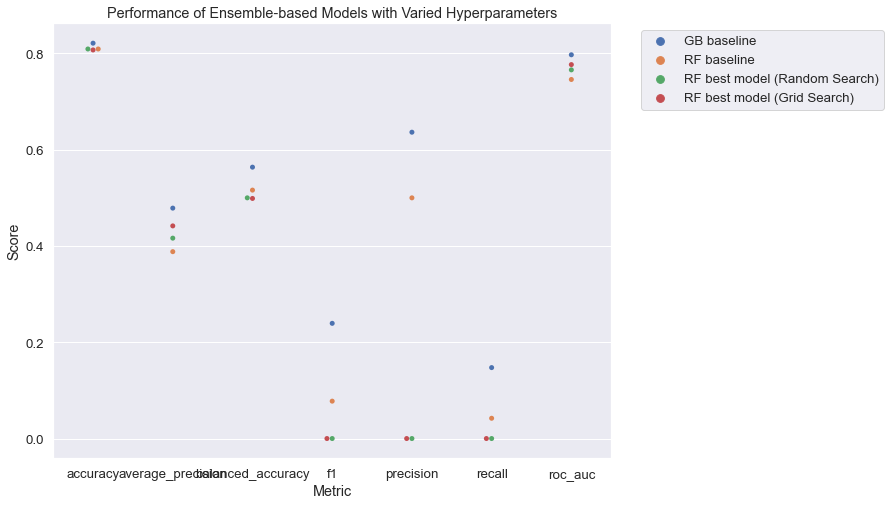

In [57]:
plot_validation_results(ensemble_results, "Ensemble-based")

### Best ensemble-based model

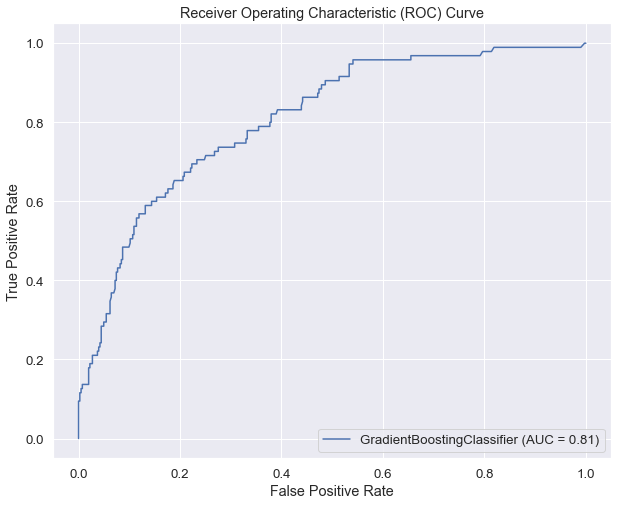

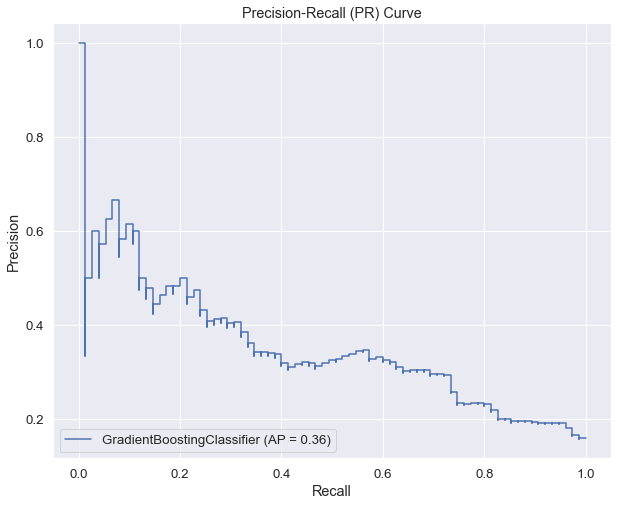

In [58]:
plot_roc_pr_curves(X_val, y_val, gb_best_model)

## Identify potentially important features

### Logistic Regression: using standard deviation scaled coefficients

https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#interpreting-coefficients-scale-matters

We can transform all model coefficients into the same scale by multiplying each feature coefficient by the standard deviation of that feature. A larger value for a feature suggests that it is more important.

In [59]:
fig_size = (30, 8)

def plot_important_features(feature_order, importances, model_name, imeasure_name):
    plt.figure(figsize=fig_size)
    plot_df = pd.DataFrame(list(zip(feature_order, importances)), 
                           columns =["Feature Name", imeasure_name])
    plot_df.sort_values(imeasure_name, ascending=False, inplace=True)
    ax = sns.barplot(data=plot_df, x="Feature Name", y=imeasure_name)
    ax.set_title("Feature Importance in %s Classifier" % model_name)
    plt.show()

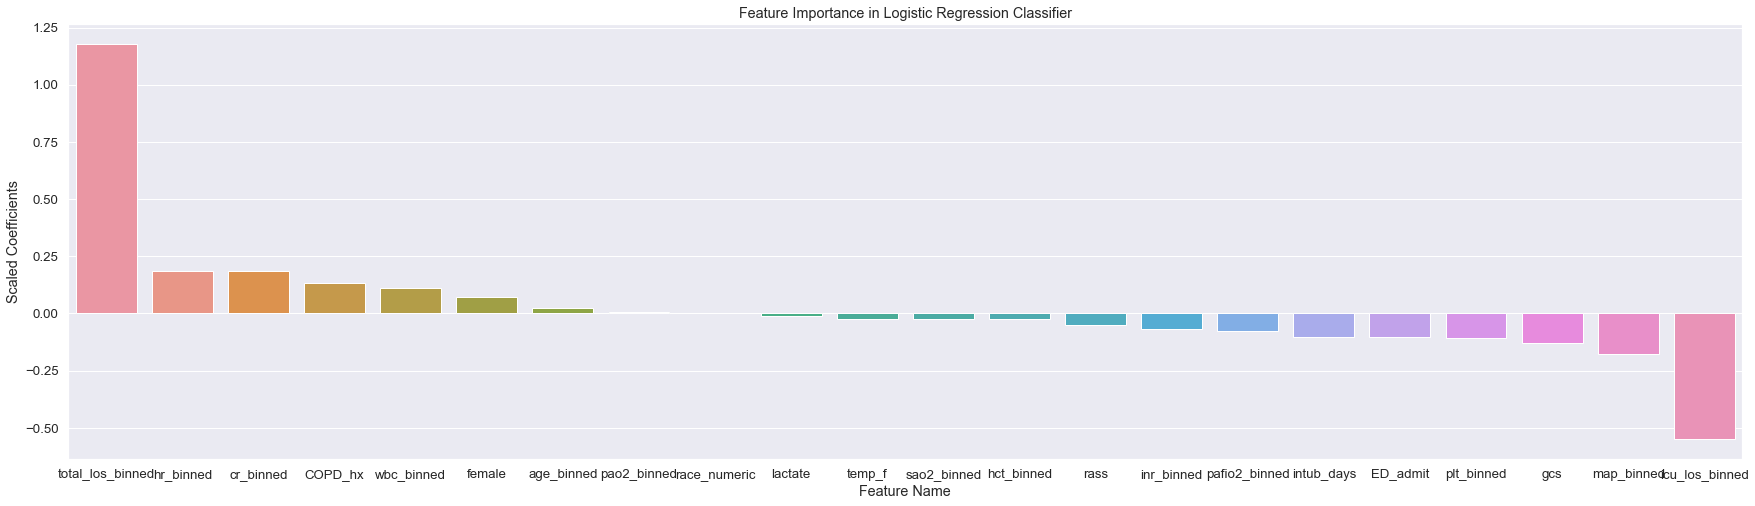

In [60]:
scaled_coeffficients = np.multiply(lr_best_model.coef_[0], X_train.std(axis=0))
plot_important_features(feature_order, scaled_coeffficients, "Logistic Regression", "Scaled Coefficients")

### Gradient Boosting and Random Forest: using impurity-based feature importances

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_

A larger value for a feature suggests that it is more important.

In [61]:
def ensemble_model_important_features(model, feature_order, model_name):
    gini_importances = model.feature_importances_
    plot_important_features(feature_order, gini_importances, model_name, "Gini Importance")

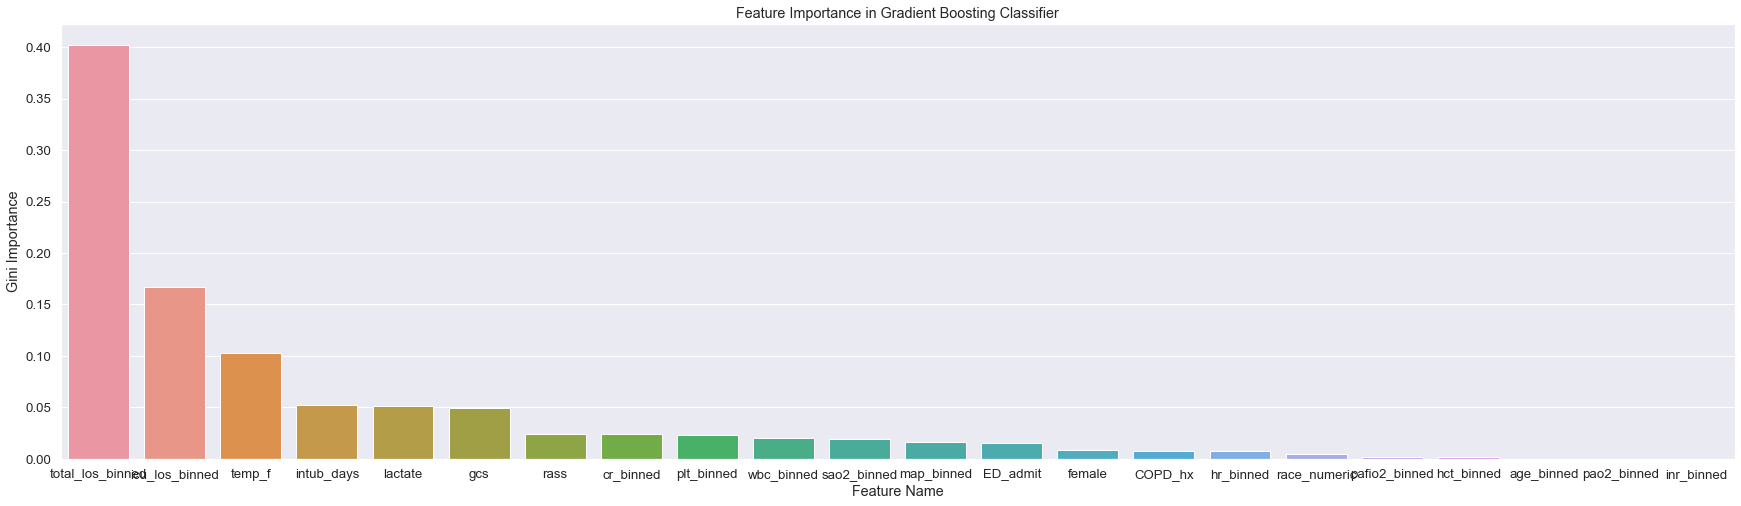

In [62]:
ensemble_model_important_features(gb_best_model, feature_order, "Gradient Boosting")

## Test and analyze best models

In [63]:
def test_model(clf, X_test, y_test, fig_size=(10,8)):
    # clf: trained classifier (i.e. after using fit function)
    y_pred = clf.predict(X_test)
    y_score = clf.decision_function(X_test)

    # print out stats
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Model accuracy: %.3f\n" % accuracy)

    # precision, recall, and f1-score is usually reported for class 1 (in binary case)
    # recall of positive class (1) = sensitivity
    # recall of negative class (0) = specificity
    # preicion of positive class (1) = PPV
    # precision of negative class (0) = NPV
    print(metrics.classification_report(y_test,y_pred))

    # confusion matrix
    cm_disp = metrics.plot_confusion_matrix(clf, X_test, y_test)  

    # ROC Curve and AUC
    auroc = metrics.roc_auc_score(y_test, y_score)
    fig_roc, ax_roc = plt.subplots(1,1,figsize=fig_size)
    roc_disp = metrics.plot_roc_curve(clf, X, y, ax=ax_roc)
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title("Receiver Operating Characteristic (ROC) Curve")

    # PR Curve and AP (average precision)
    fig, ax_pr = plt.subplots(1,1,figsize=fig_size)
    pr_disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax_pr)
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")
    ax_pr.set_title("Precision-Recall (PR) Curve")

    """
    # alternatively we can report the auc of the pr curve
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
    pr_auc = metrics.auc(precision, recall)
    pr_disp = metrics.plot_precision_recall_curve(clf, X_test, y_test, name="Precision-Recall Curve: AP=%.3f" % ap)
    """

    plt.show()

Model accuracy: 0.859

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       423
           1       0.65      0.15      0.24        75

    accuracy                           0.86       498
   macro avg       0.76      0.57      0.58       498
weighted avg       0.83      0.86      0.82       498



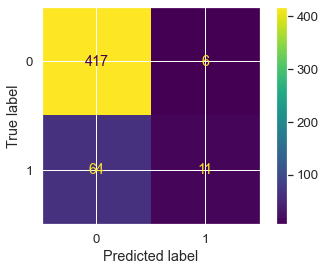

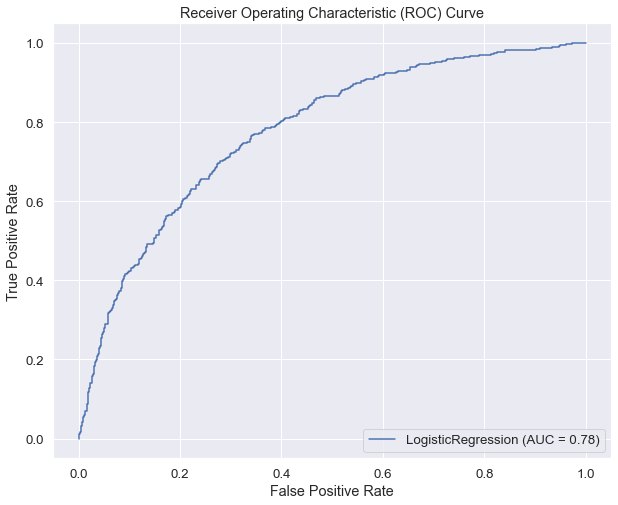

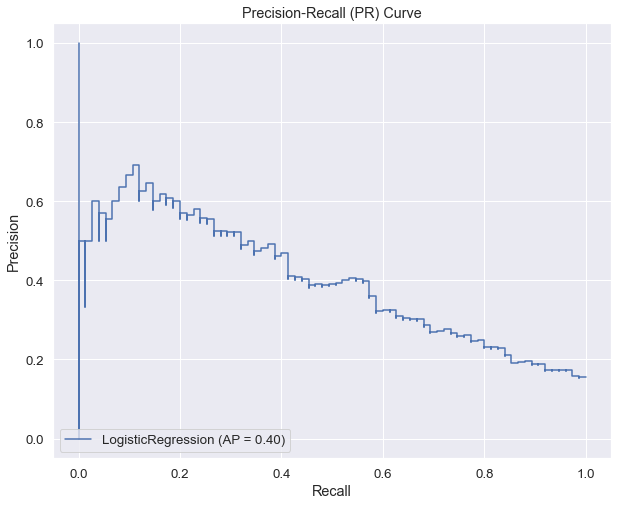

In [64]:
test_model(lr_best_model, X_test, y_test)

Model accuracy: 0.849

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       423
           1       0.50      0.01      0.03        75

    accuracy                           0.85       498
   macro avg       0.68      0.51      0.47       498
weighted avg       0.80      0.85      0.78       498



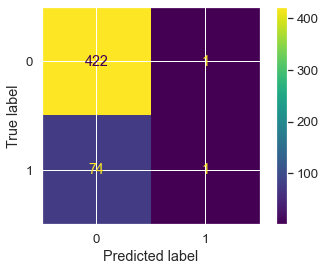

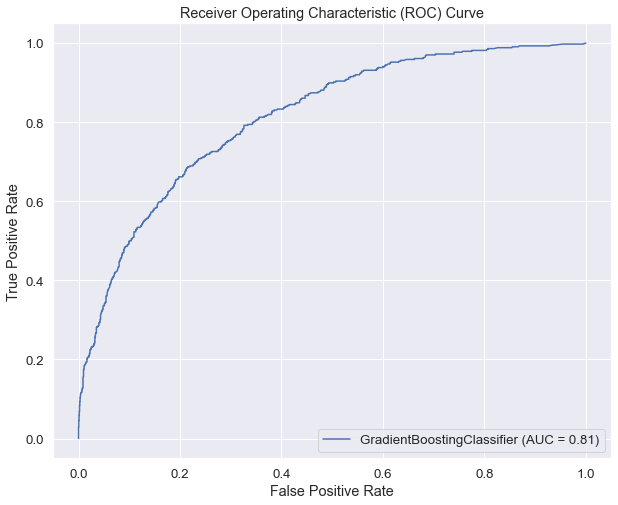

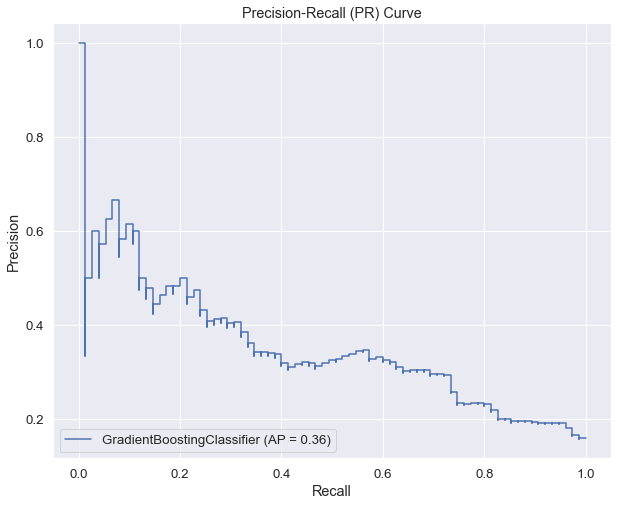

In [65]:
test_model(gb_best_model, X_test, y_test)

# Apply model to MIMIC dataset

## Load MIMIC dataset

### Fix pafio2 values to be consistent with STARR

In [95]:
mimic_file = "mimic_cohort_converted.csv"
mimic_data = pd.read_csv(mimic_file)
mimic_data.fio2 = np.where(mimic_data.fio2 < 21, np.nan, mimic_data.fio2)
mimic_data.pafio2 = mimic_data.pao2 / mimic_data.fio2
mimic_data.describe().pafio2

count    2000.000000
mean        2.716057
std         1.723086
min         0.240000
25%         1.675000
50%         2.400000
75%         3.276250
max        21.761905
Name: pafio2, dtype: float64

In [96]:
mimic_data.describe()

,id,HADM_ID,ICUSTAY_ID,LOS,age,age_bin,COPD_hx,wbc,hct,plt,cr,lactate,tbili,inr,fio2,pao2,pafio2,hr,temp_f,sao2,map,rass,gcs,intub_days,extub_hrs,readmit,female,ED_admit,icu_los,total_los
count,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5011.000000,5012.000000,5013.000000,5013.000000,4631.000000,4240.000000,4946.000000,2091.000000,4628.000000,2000.000000,3745.000000,4950.000000,4959.000000,55.000000,1124.000000,4645.000000,4483.000000,3980.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000
mean,37584.123339,150428.829665,250378.126909,9.263356,74.962919,1.338489,0.004957,12.004666,30.391620,255.564931,1.524676,1.981905,2.023962,1.512962,48.512195,114.573250,2.716057,77.117490,97.920881,91.246219,27.016364,-1.079181,11.736060,8.161053,42.917359,0.088439,0.453302,0.512790,8.754511,10.133056
std,29342.157525,28675.644499,28556.040932,9.232312,54.136014,0.621766,0.070241,9.909478,4.847231,161.921465,1.545500,2.483174,5.365758,1.045521,17.287970,56.706781,1.723086,29.524102,4.617865,16.336952,24.005445,1.920493,4.359354,8.670292,51.812357,0.283961,0.497864,0.499886,9.226298,10.515697
min,94.000000,100016.000000,200059.000000,1.002500,0.000000,0.000000,0.000000,0.100000,11.900000,5.000000,0.000000,0.050000,0.000000,0.800000,21.000000,16.000000,0.240000,0.000000,0.000000,0.000000,8.000000,-5.000000,1.000000,1.000000,-0.860556,0.000000,0.000000,0.000000,1.000000,1.000000
25%,13312.000000,125980.000000,225964.500000,3.178400,53.000000,1.000000,0.000000,7.600000,27.100000,146.000000,0.600000,1.000000,0.300000,1.100000,40.000000,81.000000,1.675000,69.000000,97.300003,93.000000,17.000000,-2.000000,9.000000,3.000000,9.488611,0.000000,0.000000,0.000000,3.000000,3.000000
50%,27100.000000,150864.000000,250647.000000,6.171800,66.000000,1.000000,0.000000,10.300000,30.000000,228.000000,0.900000,1.300000,0.600000,1.200000,40.000000,101.000000,2.400000,82.000000,98.100000,96.000000,20.000000,0.000000,14.000000,5.000000,29.639861,0.000000,0.000000,1.000000,6.000000,7.000000
75%,61820.500000,175385.500000,274572.500000,12.004950,78.000000,2.000000,0.000000,14.300000,33.100000,331.000000,1.700000,1.900000,1.100000,1.500000,50.000000,133.000000,3.276250,95.000000,98.900002,98.000000,27.150000,0.000000,15.000000,10.000000,55.461667,0.000000,1.000000,1.000000,12.000000,13.000000
max,99985.000000,199994.000000,299992.000000,104.248300,309.000000,2.000000,1.000000,462.600000,55.300000,1407.000000,14.400000,27.700000,63.600000,27.400000,100.000000,542.000000,21.761905,200.000000,107.900002,100.000000,135.000000,3.000000,15.000000,102.000000,752.407778,1.000000,1.000000,1.000000,104.000000,130.000000


### Drop all unnecessary columns

In [93]:
cols_keep = ["id", "readmit", "total_los", "icu_los", "intub_days", "age", "female", "race", "ED_admit", "COPD_hx",
             "hct", "wbc", "inr", "cr", "plt", "sao2", "hr", "map", "gcs", "lactate", "rass", "temp_f", "pao2", "pafio2"]
mimic_data = mimic_data[cols_keep]
mimic_data.head()

,id,readmit,total_los,icu_los,intub_days,age,female,race,ED_admit,COPD_hx,hct,wbc,inr,cr,plt,sao2,hr,map,gcs,lactate,rass,temp_f,pao2,pafio2
0,68591,0.0,6,6,5.0,56,0,White,0,0.0,26.7,8.1,1.7,1.1,130.0,100.0,108.0,NaN,10.0,2.0,0.0,96.800000,86.0,2.150000
1,48539,0.0,10,10,8.0,37,0,Hispanic/Latino,0,0.0,41.7,21.2,1.2,1.2,203.0,95.0,NaN,NaN,14.0,1.0,0.0,98.100000,95.0,1.357143
2,69282,0.0,2,1,1.0,46,0,Hispanic/Latino,1,0.0,40.9,9.3,1.0,1.0,183.0,96.0,80.0,NaN,15.0,NaN,-1.0,100.200000,365.0,7.300000
3,42255,0.0,3,3,4.0,57,0,White,0,0.0,44.8,8.5,1.5,0.7,215.0,81.0,NaN,NaN,4.0,1.3,-5.0,98.100000,143.0,4.766667
4,19984,0.0,18,18,7.0,74,1,Black,1,0.0,27.6,10.0,1.0,1.3,316.0,97.0,84.0,NaN,15.0,1.2,NaN,99.199997,97.0,NaN


## Preprocess MIMIC dataset

### Replace incorrect values

In [69]:
mimic_data.describe()

,id,readmit,total_los,icu_los,intub_days,age,female,ED_admit,COPD_hx,hct,wbc,inr,cr,plt,sao2,hr,map,gcs,lactate,rass,temp_f,pao2,pafio2
count,5043.000000,5043.000000,5043.000000,5043.000000,4483.000000,5043.000000,5043.000000,5043.000000,5043.000000,5012.000000,5011.000000,4946.000000,5013.000000,5013.000000,4959.000000,3745.000000,55.000000,4645.000000,4631.000000,1124.000000,4950.000000,4628.000000,2000.000000
mean,37584.123339,0.088439,10.133056,8.754511,8.161053,74.962919,0.453302,0.512790,0.004957,30.391620,12.004666,1.512962,1.524676,255.564931,91.246219,77.117490,27.016364,11.736060,1.981905,-1.079181,97.920881,114.573250,2.716057
std,29342.157525,0.283961,10.515697,9.226298,8.670292,54.136014,0.497864,0.499886,0.070241,4.847231,9.909478,1.045521,1.545500,161.921465,16.336952,29.524102,24.005445,4.359354,2.483174,1.920493,4.617865,56.706781,1.723086
min,94.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.900000,0.100000,0.800000,0.000000,5.000000,0.000000,0.000000,8.000000,1.000000,0.050000,-5.000000,0.000000,16.000000,0.240000
25%,13312.000000,0.000000,3.000000,3.000000,3.000000,53.000000,0.000000,0.000000,0.000000,27.100000,7.600000,1.100000,0.600000,146.000000,93.000000,69.000000,17.000000,9.000000,1.000000,-2.000000,97.300003,81.000000,1.675000
50%,27100.000000,0.000000,7.000000,6.000000,5.000000,66.000000,0.000000,1.000000,0.000000,30.000000,10.300000,1.200000,0.900000,228.000000,96.000000,82.000000,20.000000,14.000000,1.300000,0.000000,98.100000,101.000000,2.400000
75%,61820.500000,0.000000,13.000000,12.000000,10.000000,78.000000,1.000000,1.000000,0.000000,33.100000,14.300000,1.500000,1.700000,331.000000,98.000000,95.000000,27.150000,15.000000,1.900000,0.000000,98.900002,133.000000,3.276250
max,99985.000000,1.000000,130.000000,104.000000,102.000000,309.000000,1.000000,1.000000,1.000000,55.300000,462.600000,27.400000,14.400000,1407.000000,100.000000,200.000000,135.000000,15.000000,27.700000,3.000000,107.900002,542.000000,21.761905


In [70]:
"""
In the MIMIC III clinical database description it states: 
"Dates of birth for patients aged over 89 were shifted to 
obscure their true age and comply with HIPAA regulations: 
these patients appear in the database with ages of over 300 years."
"""
# For age >= 300, shift by subtracting 300 and adding 90 (or just subtracting 210)
print("number of patients with age >= 300: %d" % sum(mimic_data.age >= 300))
mimic_data.age = np.where(mimic_data.age >= 300, mimic_data.age - 210, mimic_data.age)

# For values of hr < 50, make NA
print("number of patients with hr < 50: %d" % sum(mimic_data.hr < 50))
mimic_data.hr = np.where(mimic_data.hr < 50, np.nan, mimic_data.hr)

# For values of temp_f < 85, make NA
print("number of patients with temp_f < 85: %d" % sum(mimic_data.hr < 50))
mimic_data.temp_f = np.where(mimic_data.temp_f < 85, np.nan, mimic_data.temp_f)

# For values of pafio2 > 5, make NA
mimic_data.pafio2 = np.where(mimic_data.pafio2 > 5, np.nan, mimic_data.pafio2)

mimic_data.describe()

number of patients with age >= 300: 253
number of patients with hr < 50: 410
number of patients with temp_f < 85: 0


,id,readmit,total_los,icu_los,intub_days,age,female,ED_admit,COPD_hx,hct,wbc,inr,cr,plt,sao2,hr,map,gcs,lactate,rass,temp_f,pao2,pafio2
count,5043.000000,5043.000000,5043.000000,5043.000000,4483.000000,5043.000000,5043.000000,5043.000000,5043.000000,5012.000000,5011.000000,4946.000000,5013.000000,5013.000000,4959.000000,3335.000000,55.000000,4645.000000,4631.000000,1124.000000,4931.000000,4628.000000,1869.000000
mean,37584.123339,0.088439,10.133056,8.754511,8.161053,64.427523,0.453302,0.512790,0.004957,30.391620,12.004666,1.512962,1.524676,255.564931,91.246219,85.638081,27.016364,11.736060,1.981905,-1.079181,98.189264,114.573250,2.391603
std,29342.157525,0.283961,10.515697,9.226298,8.670292,16.723267,0.497864,0.499886,0.070241,4.847231,9.909478,1.045521,1.545500,161.921465,16.336952,16.956101,24.005445,4.359354,2.483174,1.920493,1.378568,56.706781,1.029685
min,94.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.900000,0.100000,0.800000,0.000000,5.000000,0.000000,50.000000,8.000000,1.000000,0.050000,-5.000000,85.300003,16.000000,0.240000
25%,13312.000000,0.000000,3.000000,3.000000,3.000000,53.000000,0.000000,0.000000,0.000000,27.100000,7.600000,1.100000,0.600000,146.000000,93.000000,73.000000,17.000000,9.000000,1.000000,-2.000000,97.300003,81.000000,1.633333
50%,27100.000000,0.000000,7.000000,6.000000,5.000000,66.000000,0.000000,1.000000,0.000000,30.000000,10.300000,1.200000,0.900000,228.000000,96.000000,84.000000,20.000000,14.000000,1.300000,0.000000,98.199997,101.000000,2.300000
75%,61820.500000,0.000000,13.000000,12.000000,10.000000,78.000000,1.000000,1.000000,0.000000,33.100000,14.300000,1.500000,1.700000,331.000000,98.000000,96.000000,27.150000,15.000000,1.900000,0.000000,98.900002,133.000000,3.028571
max,99985.000000,1.000000,130.000000,104.000000,102.000000,99.000000,1.000000,1.000000,1.000000,55.300000,462.600000,27.400000,14.400000,1407.000000,100.000000,200.000000,135.000000,15.000000,27.700000,3.000000,107.900002,542.000000,5.000000


### Feature engineering that is consistent with that of STARR data

In [71]:
mimic_data = impute_missing_values(mimic_data)

column name: total_los
number of NaN values: 0
imputation value (mean): 10.133

column name: icu_los
number of NaN values: 0
imputation value (mean): 8.755

column name: intub_days
number of NaN values: 560
imputation value (mean): 8.161

column name: age
number of NaN values: 0
imputation value (mean): 64.428

column name: female
number of NaN values: 0
imputation value (mean): 0.453

column name: ED_admit
number of NaN values: 0
imputation value (mean): 0.513

column name: COPD_hx
number of NaN values: 0
imputation value (mean): 0.005

column name: hct
number of NaN values: 31
imputation value (mean): 30.392

column name: wbc
number of NaN values: 32
imputation value (mean): 12.005

column name: inr
number of NaN values: 97
imputation value (mean): 1.513

column name: cr
number of NaN values: 30
imputation value (mean): 1.525

column name: plt
number of NaN values: 30
imputation value (mean): 255.565

column name: sao2
number of NaN values: 84
imputation value (mean): 91.246

column 

In [72]:
cols_binned, mimic_data = bin_columns(mimic_data)

`total_los` bin map
range: label
(-inf, 7]: 0
(7, 15]: 1
(15, 30]: 2
(30, inf]: 3

`icu_los` bin map
range: label
(-inf, 7]: 0
(7, 15]: 1
(15, 30]: 2
(30, inf]: 3

`age` bin map
range: label
(-inf, 50]: 0
(50, 75]: 1
(75, inf]: 2

`hct` bin map
range: label
(-inf, 25]: 0
(25, 50]: 1
(50, inf]: 2

`wbc` bin map
range: label
(-inf, 4.5]: 0
(4.5, 11]: 1
(11, inf]: 2

`inr` bin map
range: label
(-inf, 1.1]: 0
(1.1, 2.0]: 1
(2.0, 3.0]: 2
(3.0, inf]: 3

`cr` bin map
range: label
(-inf, 1.21]: 0
(1.21, inf]: 1

`pafio2` bin map
range: label
(-inf, 1]: 0
(1, 2]: 1
(2, 3]: 2
(3, inf]: 3

`pao2` bin map
range: label
(-inf, 80]: 0
(80, 100]: 1
(100, inf]: 2

`plt` bin map
range: label
(-inf, 150]: 0
(150, 450]: 1
(450, inf]: 2

`sao2` bin map
range: label
(-inf, 80]: 0
(80, 89]: 1
(89, inf]: 2

`hr` bin map
range: label
(50, 75]: 0
(75, 100]: 1
(100, 125]: 2
(125, inf]: 3

`map` bin map
range: label
(0, 70]: 0
(70, 100]: 1
(100, inf]: 2



In [73]:
cols_numeric, mimic_data = map_to_numeric(mimic_data)

Counts table for column readmit
0.0    4597
1.0     446
Name: readmit, dtype: int64



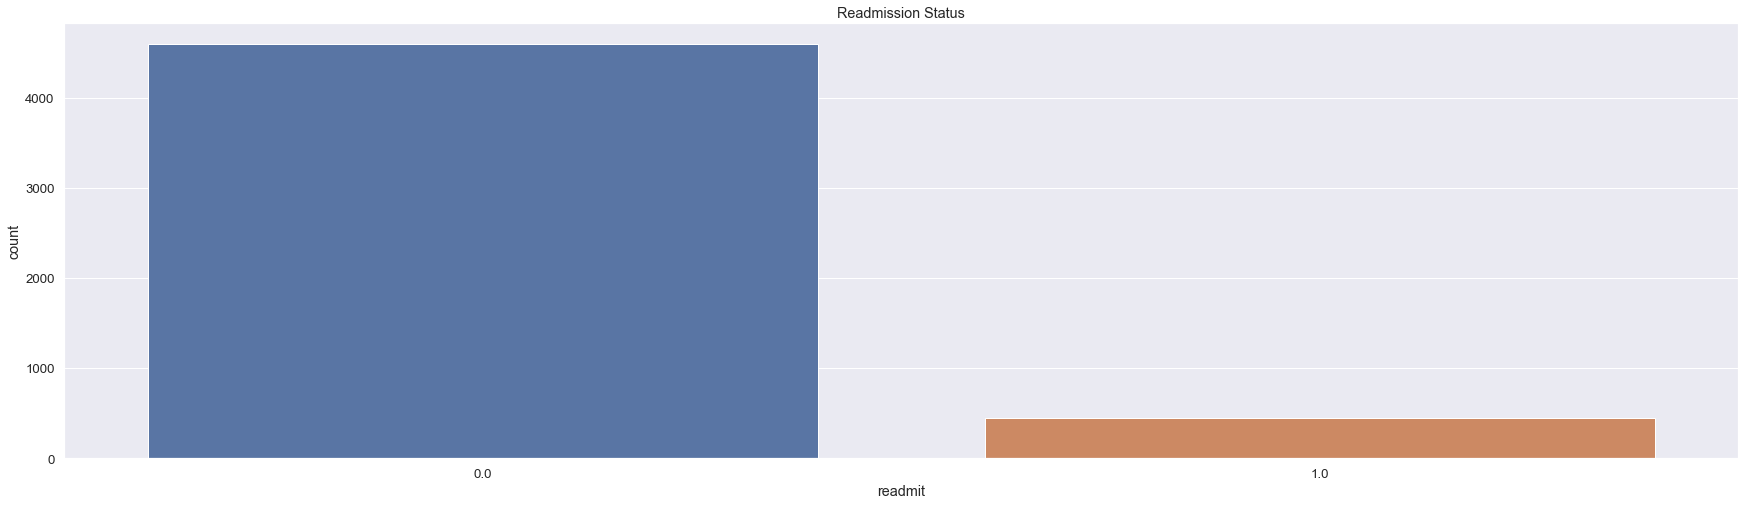

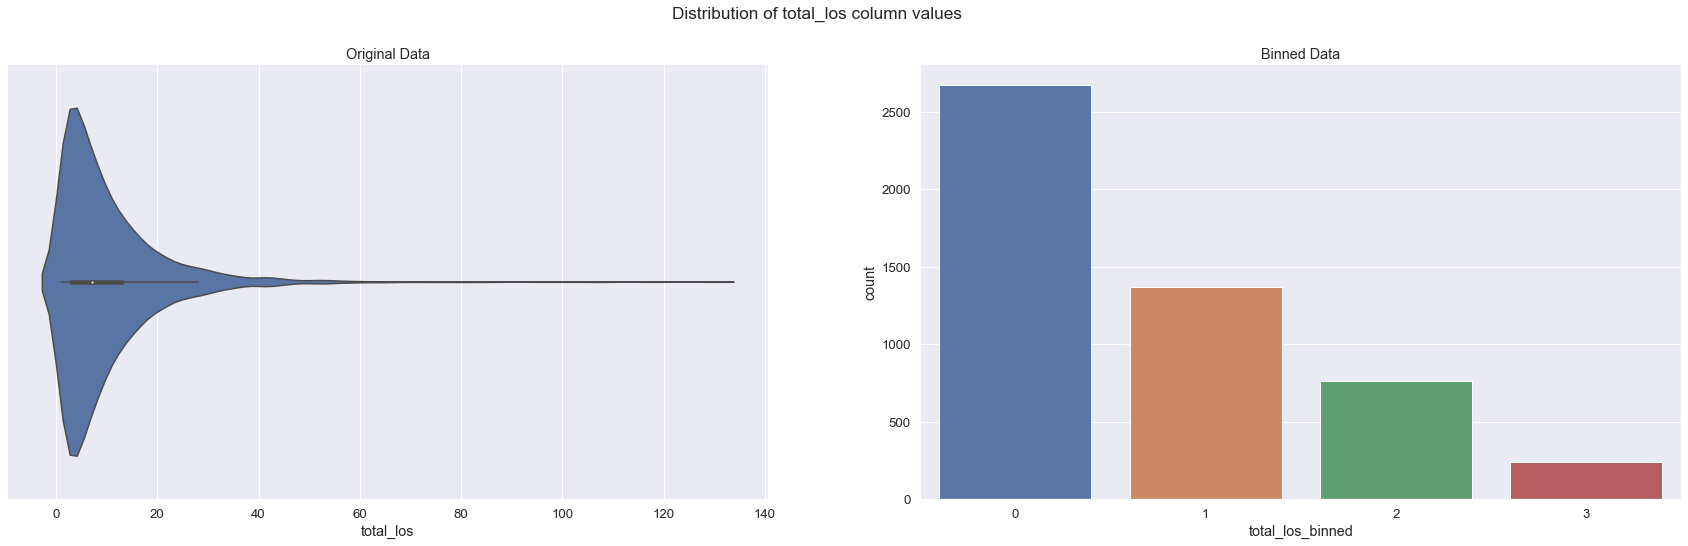

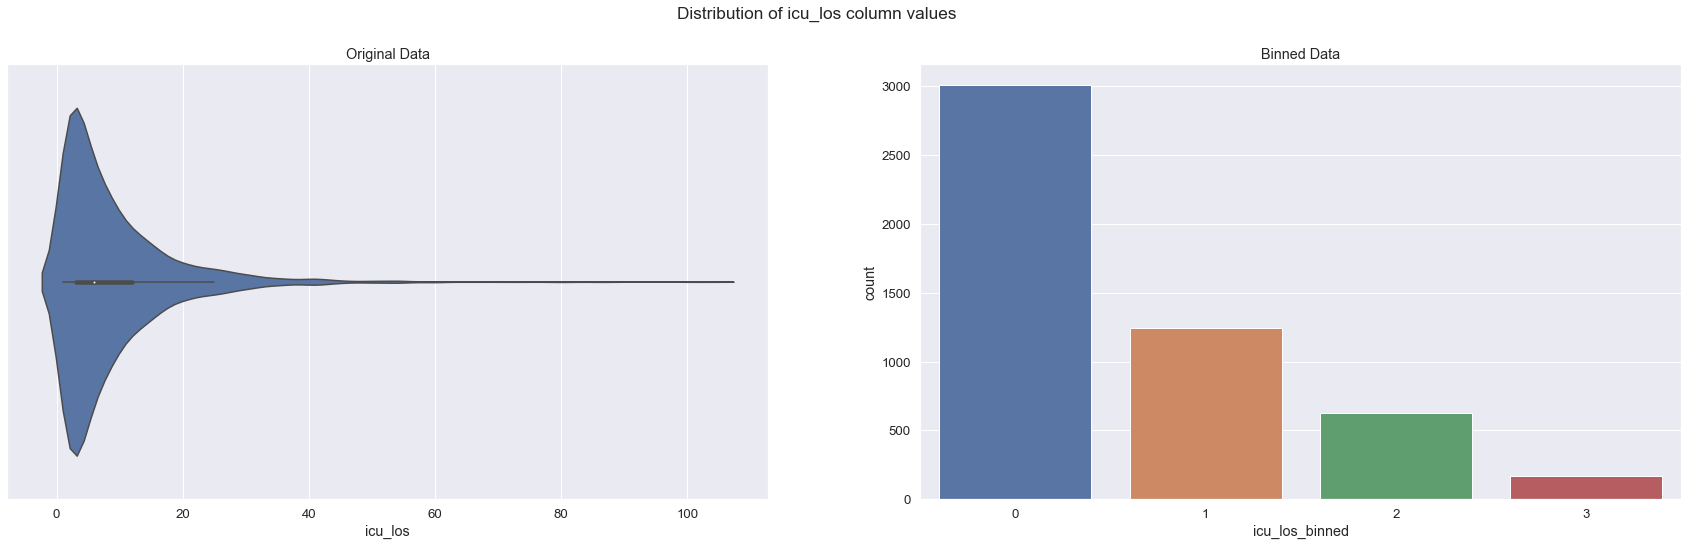

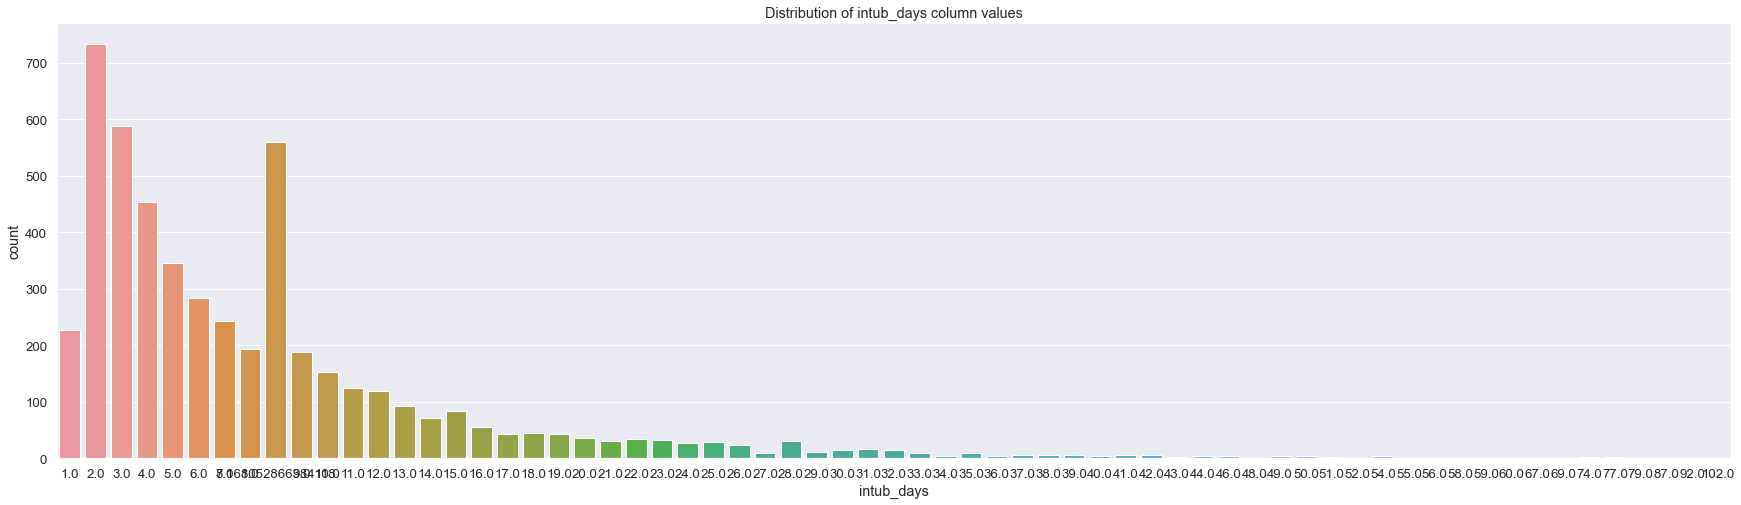

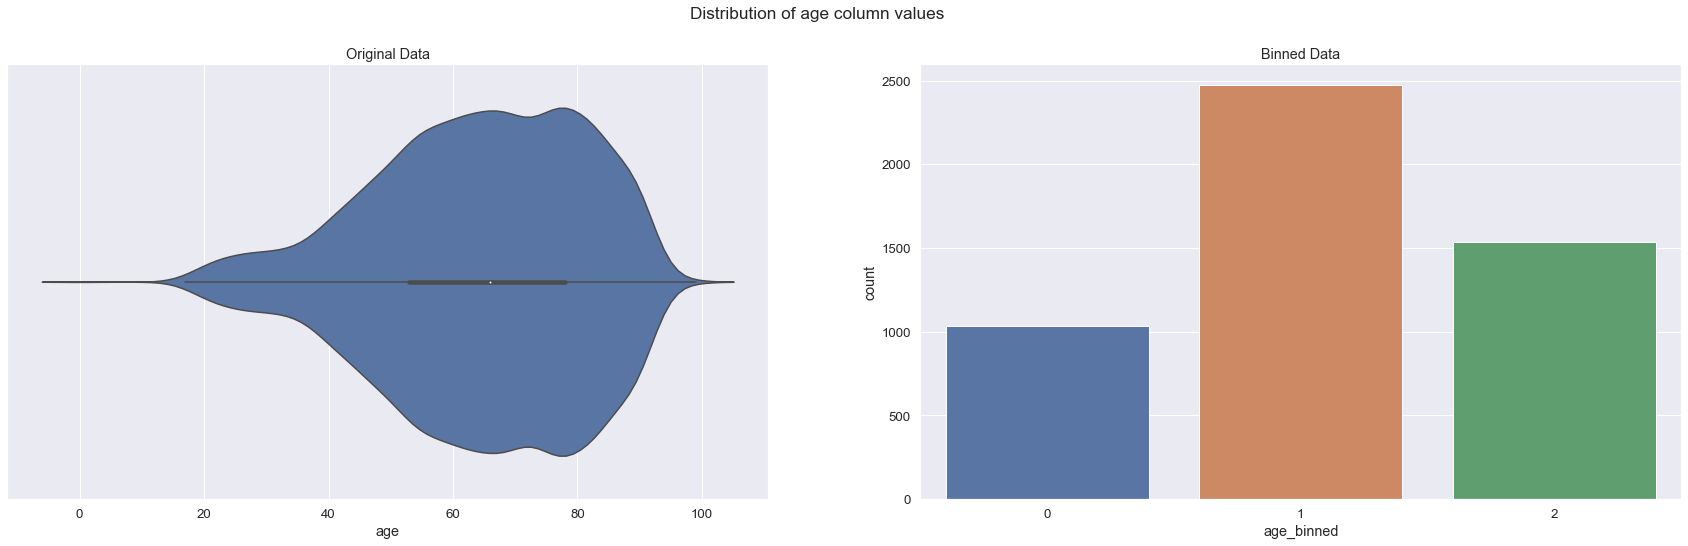

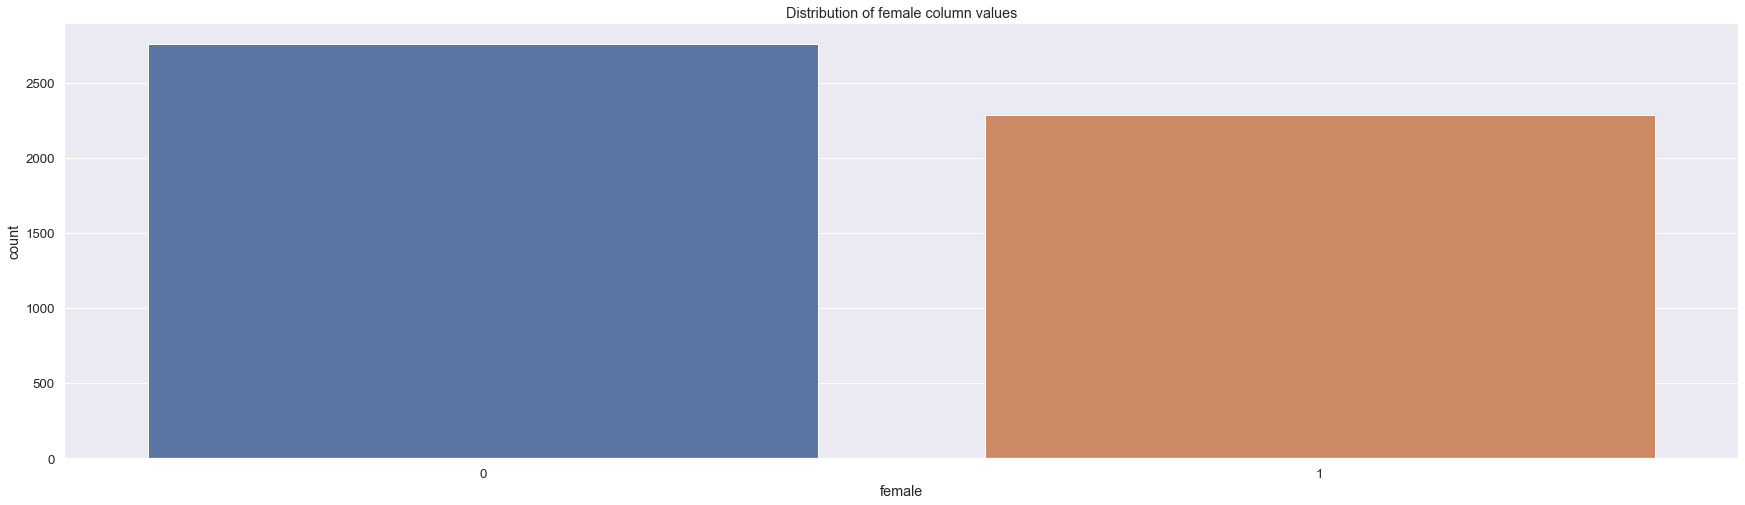

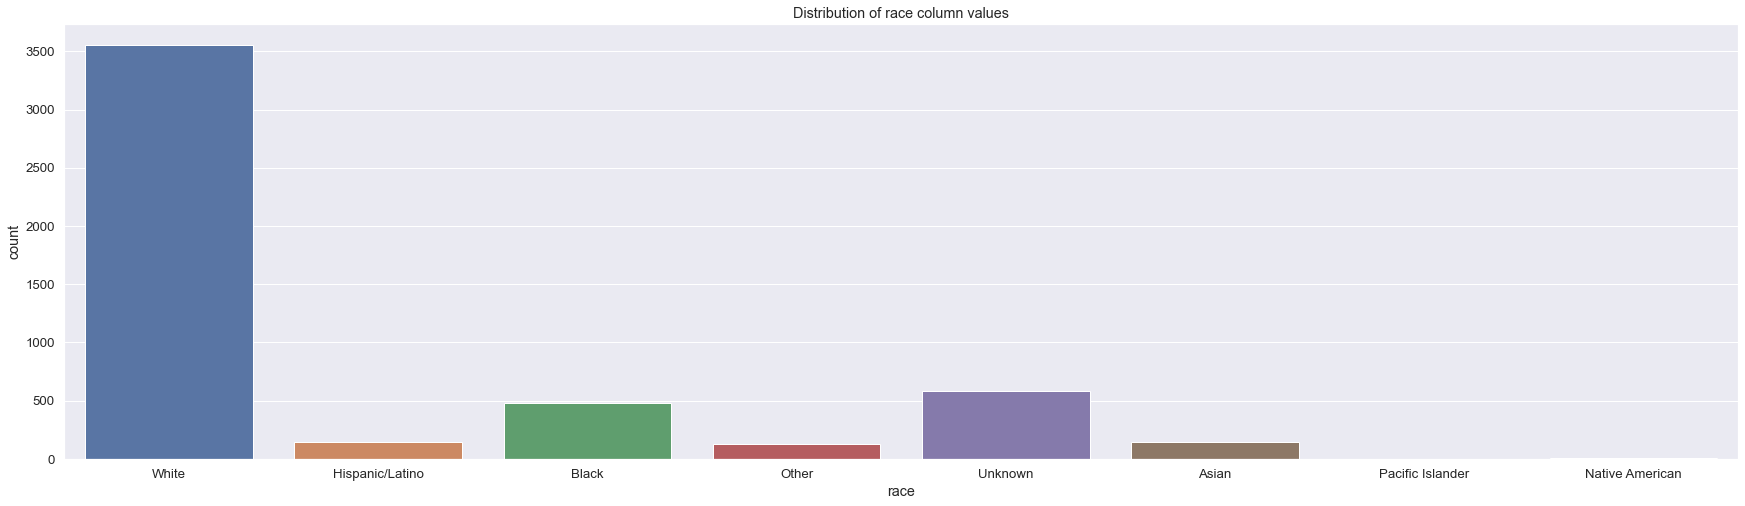

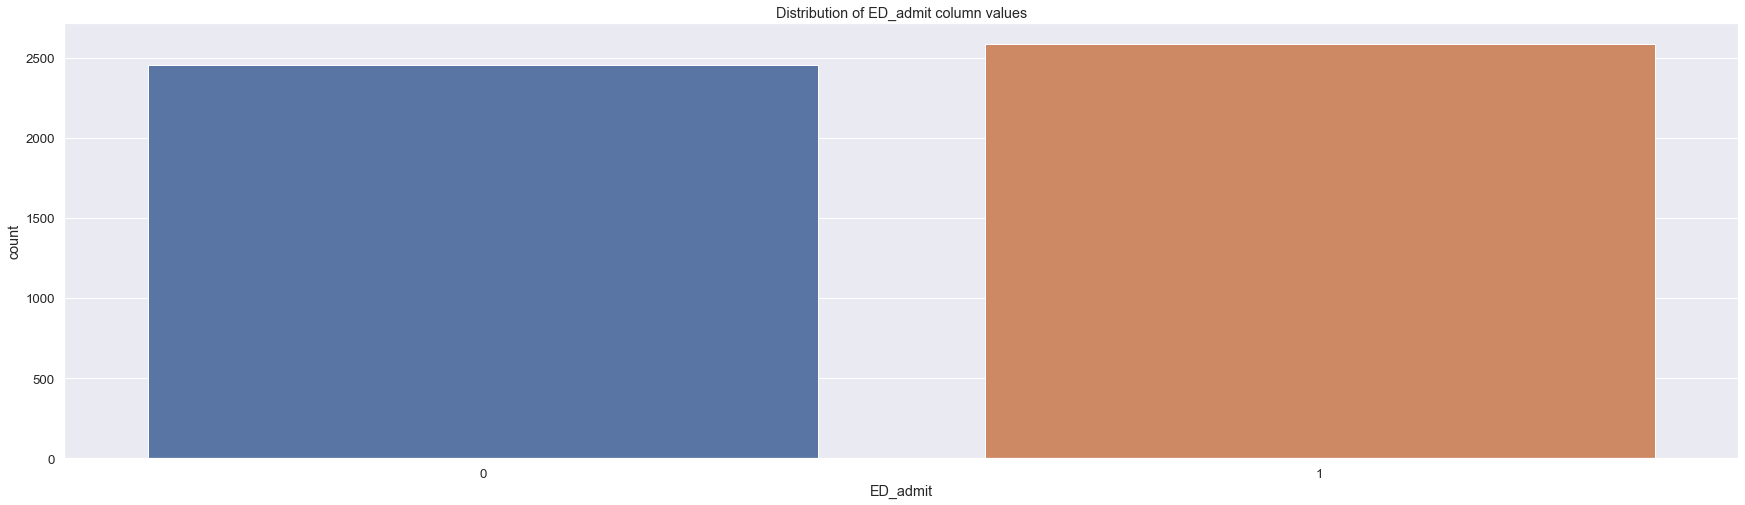

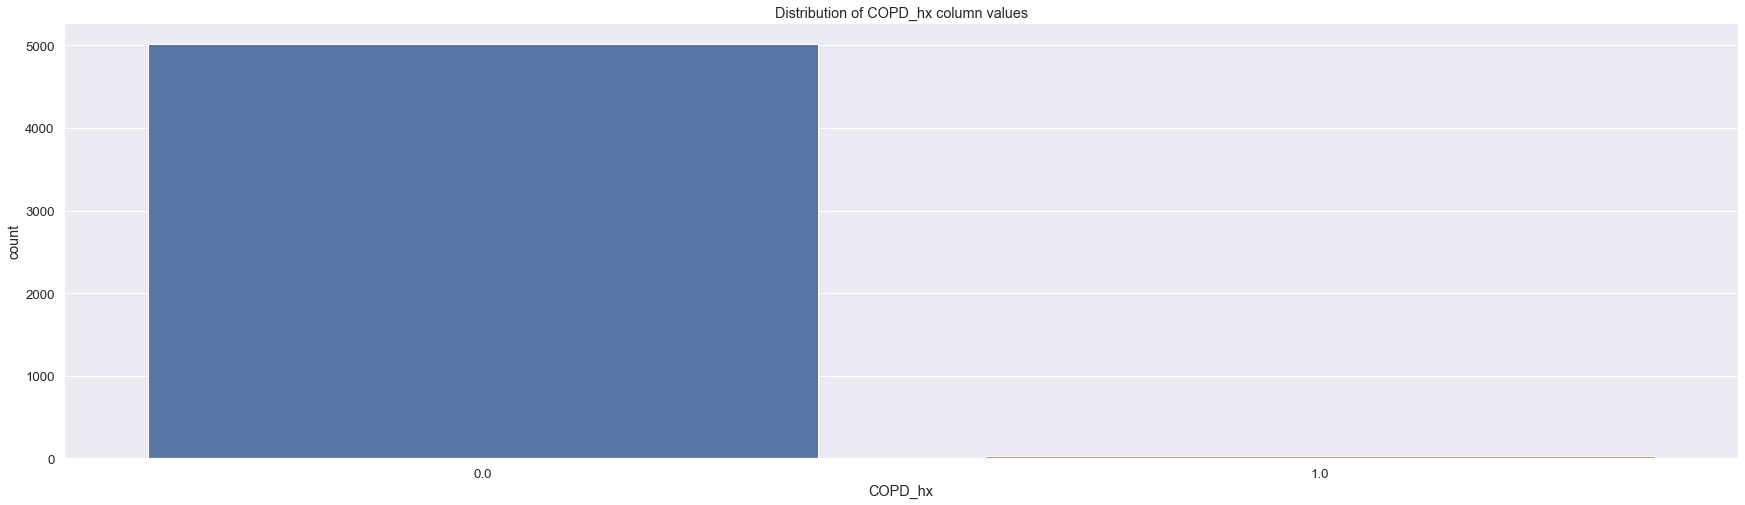

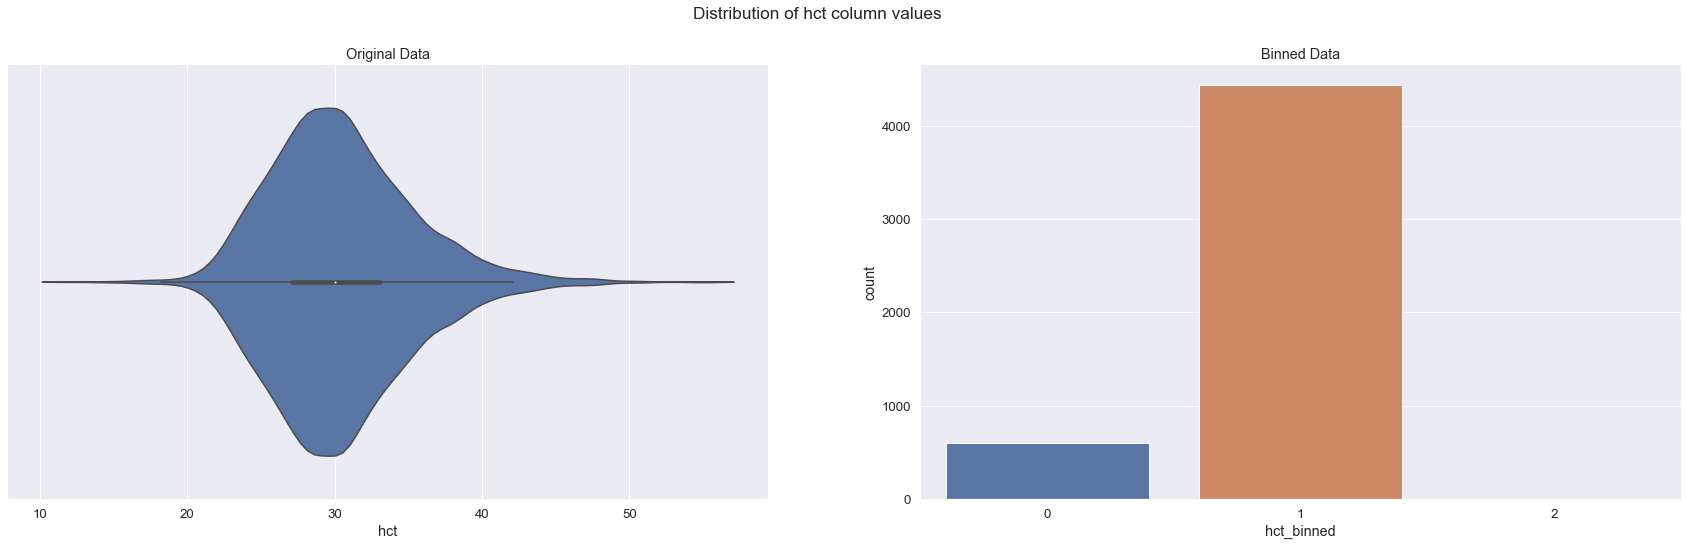

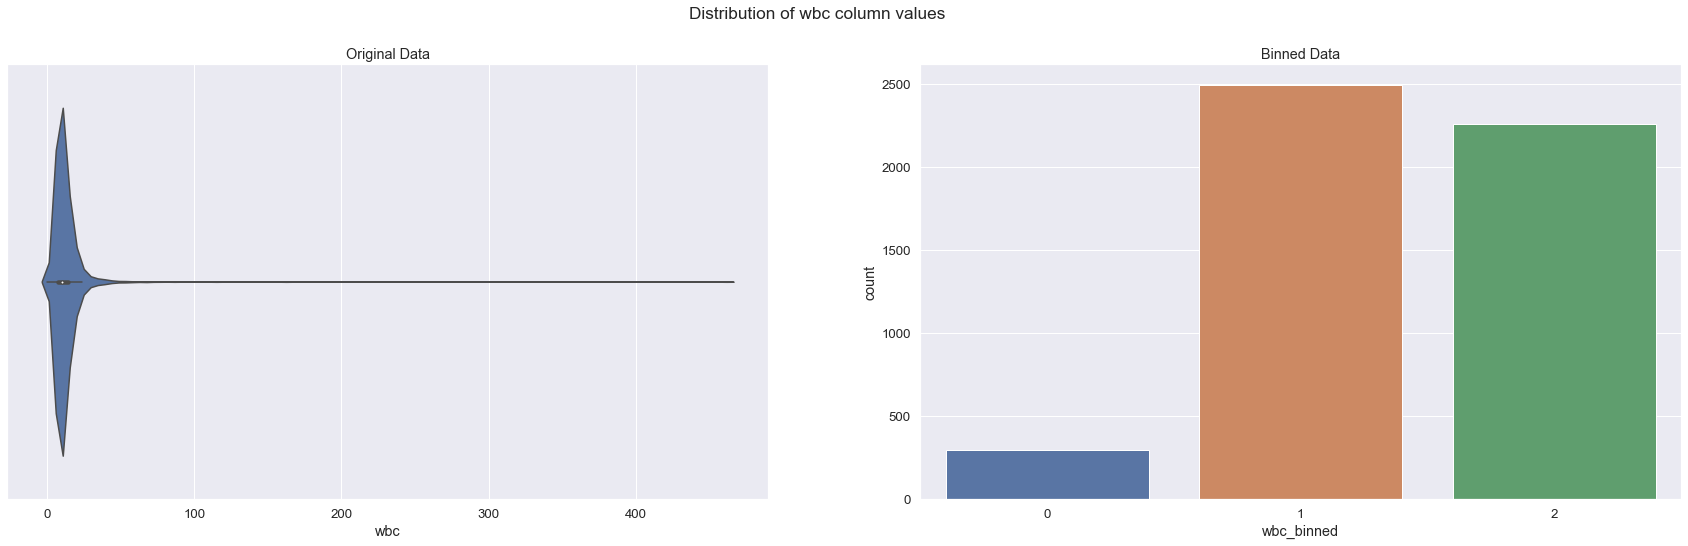

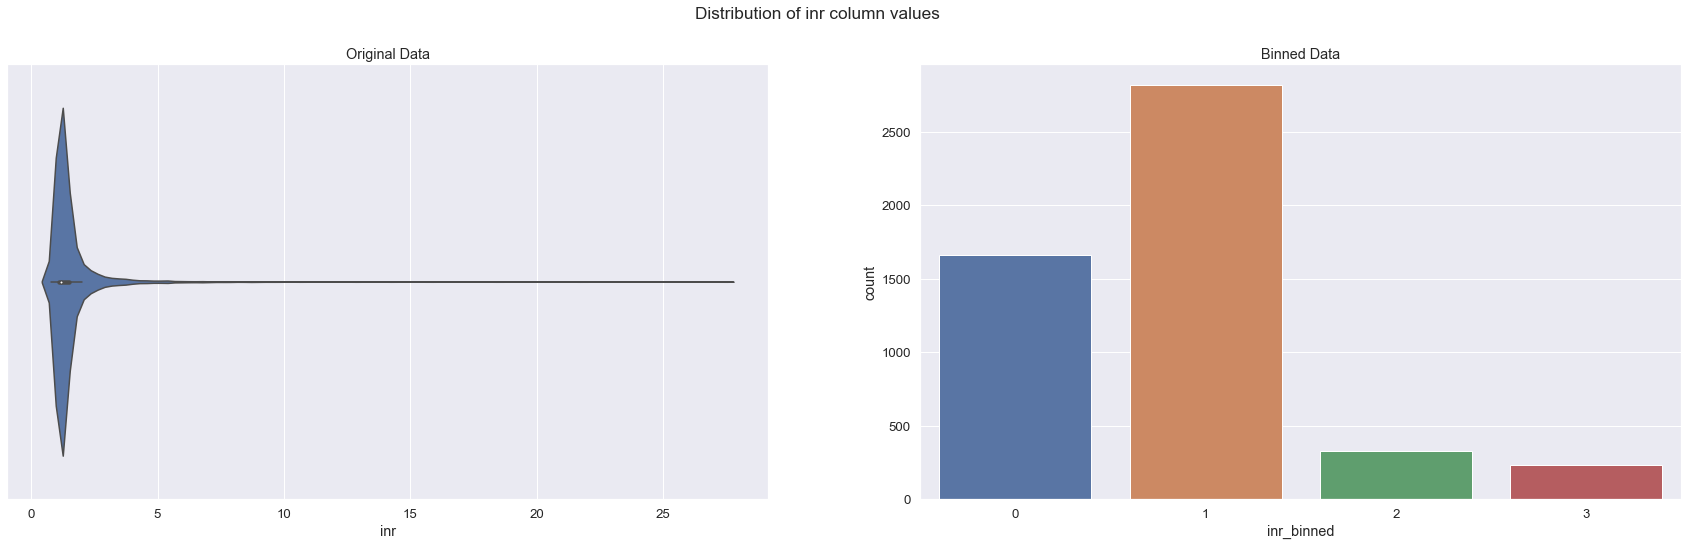

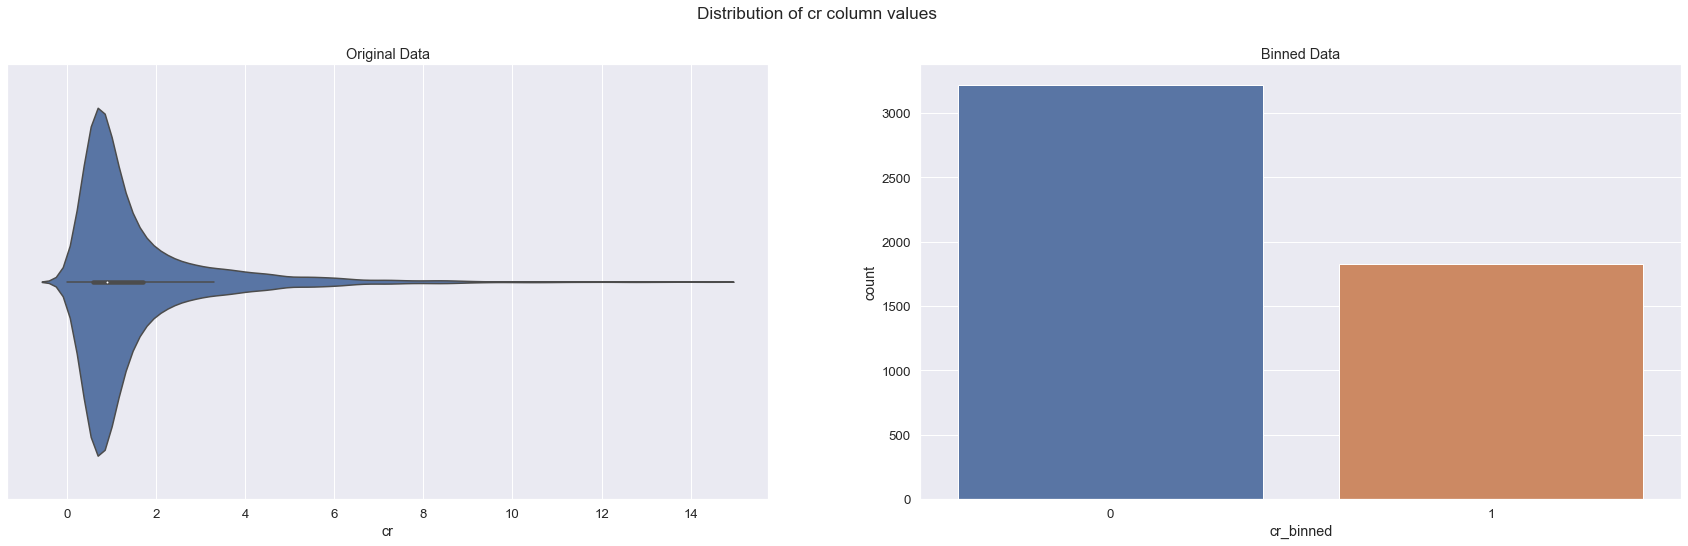

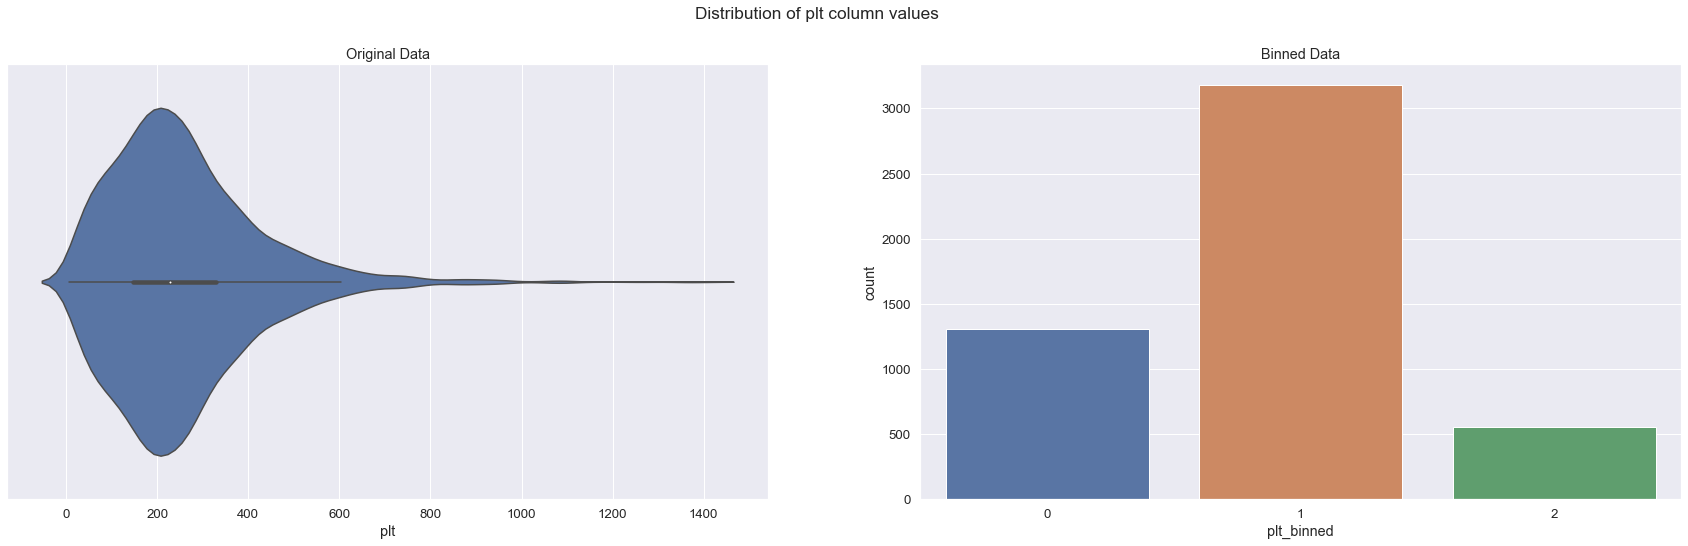

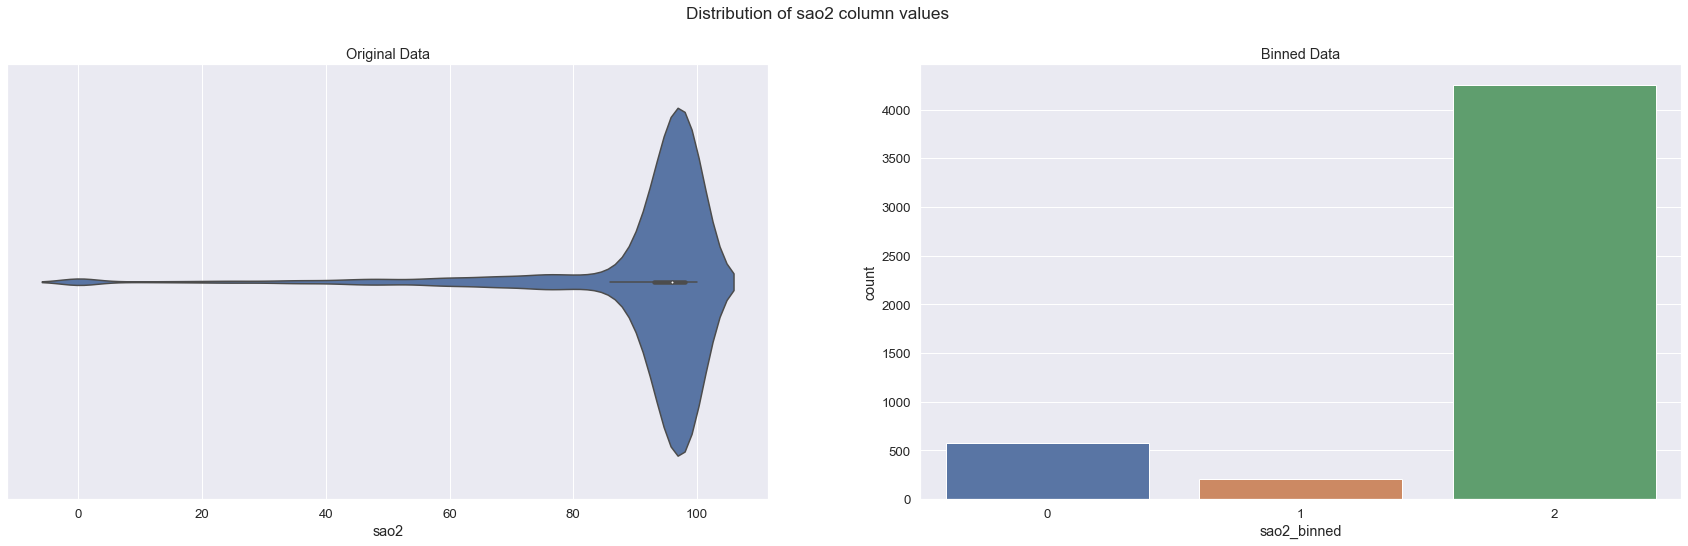

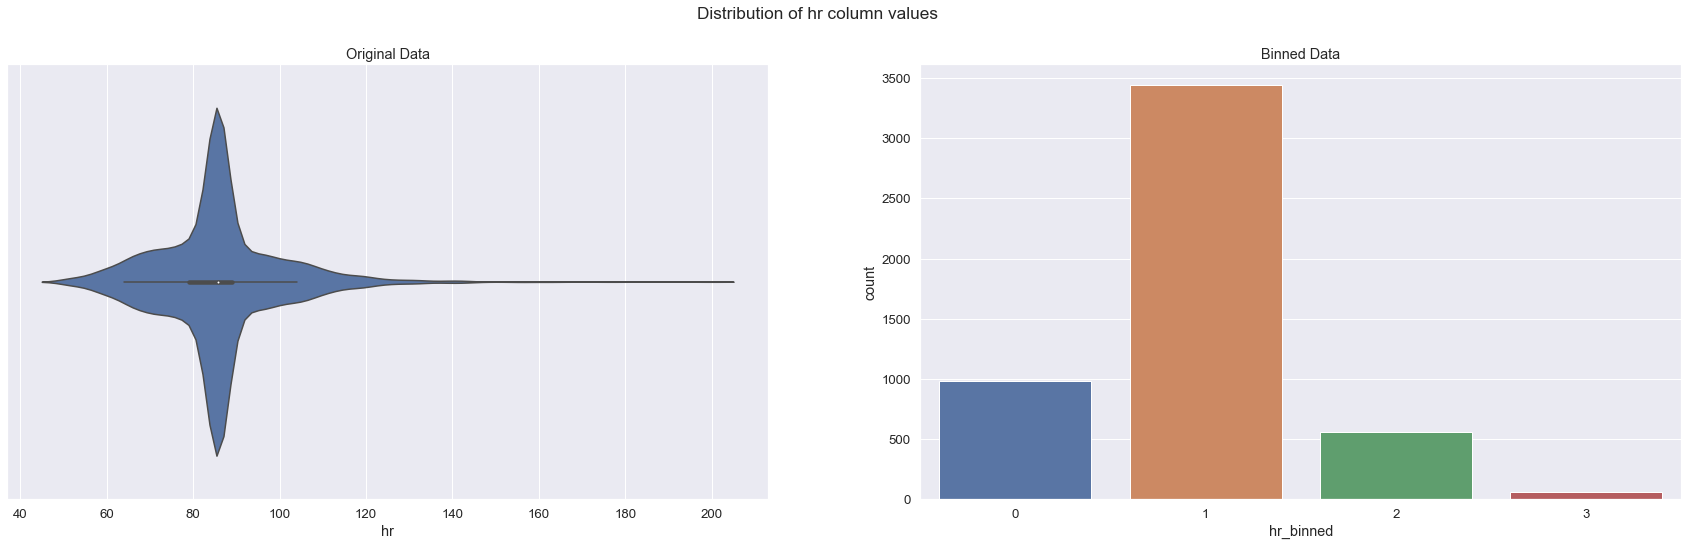

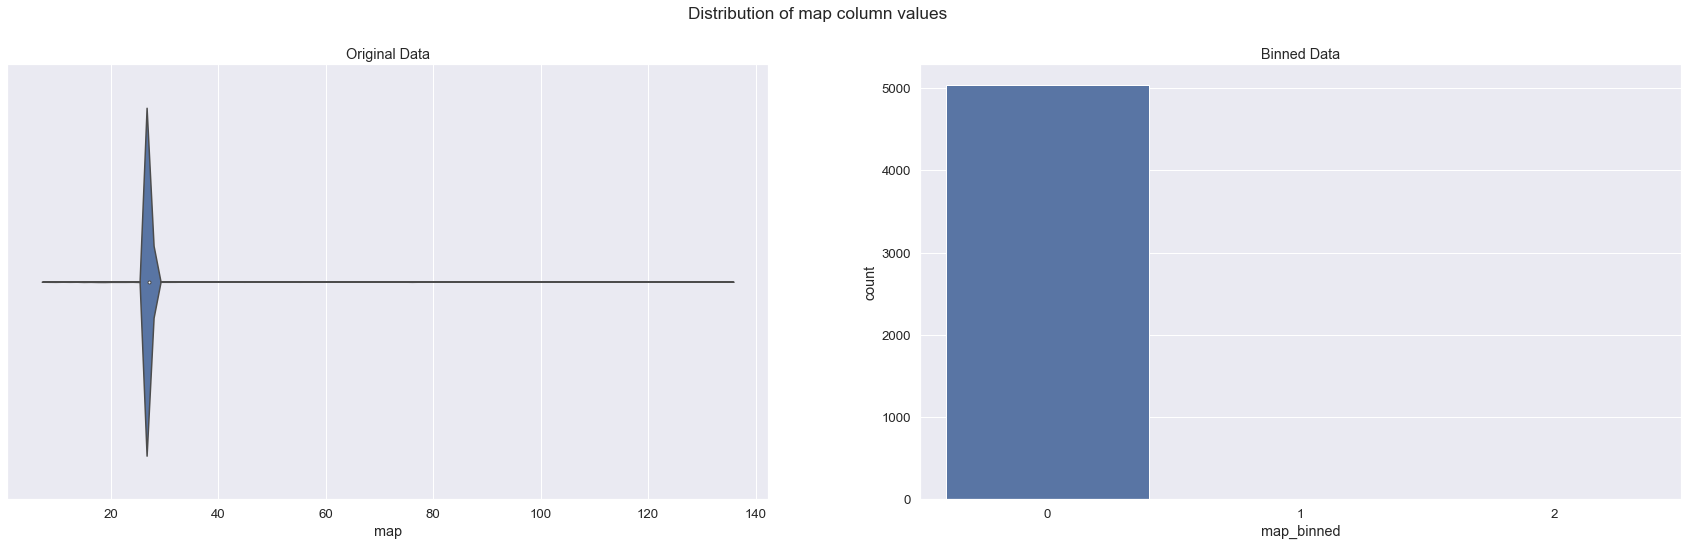

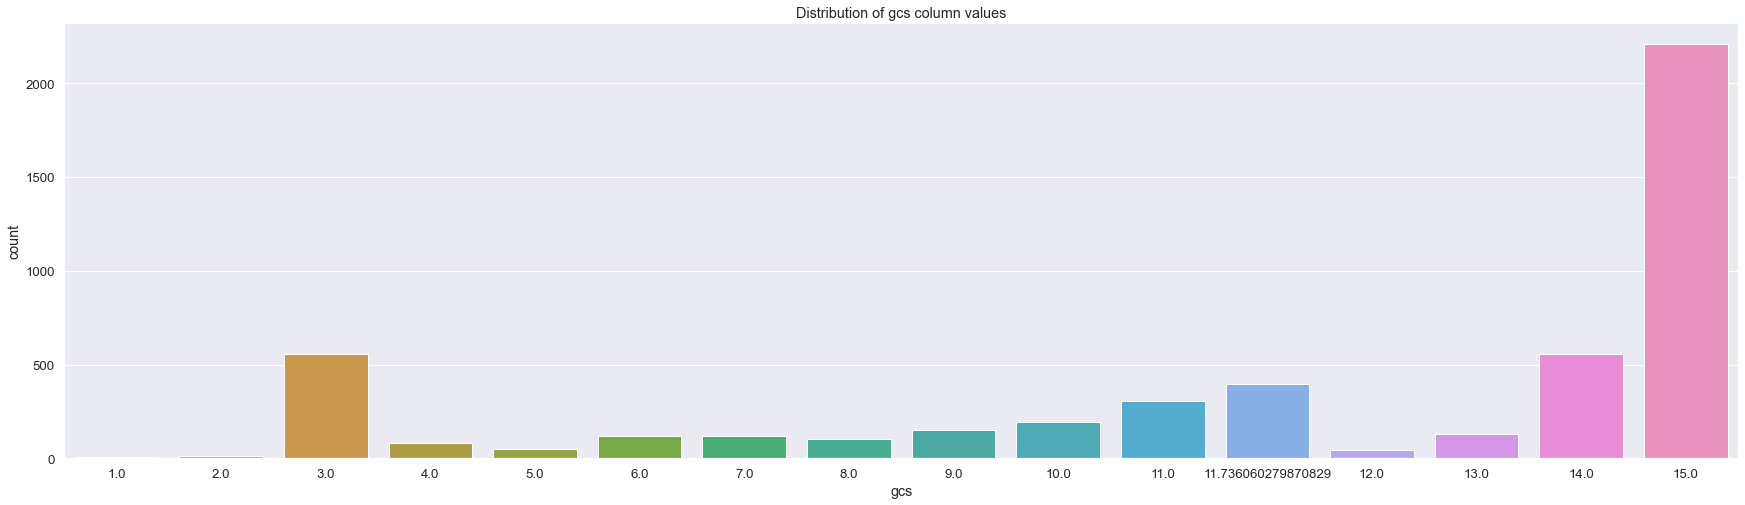

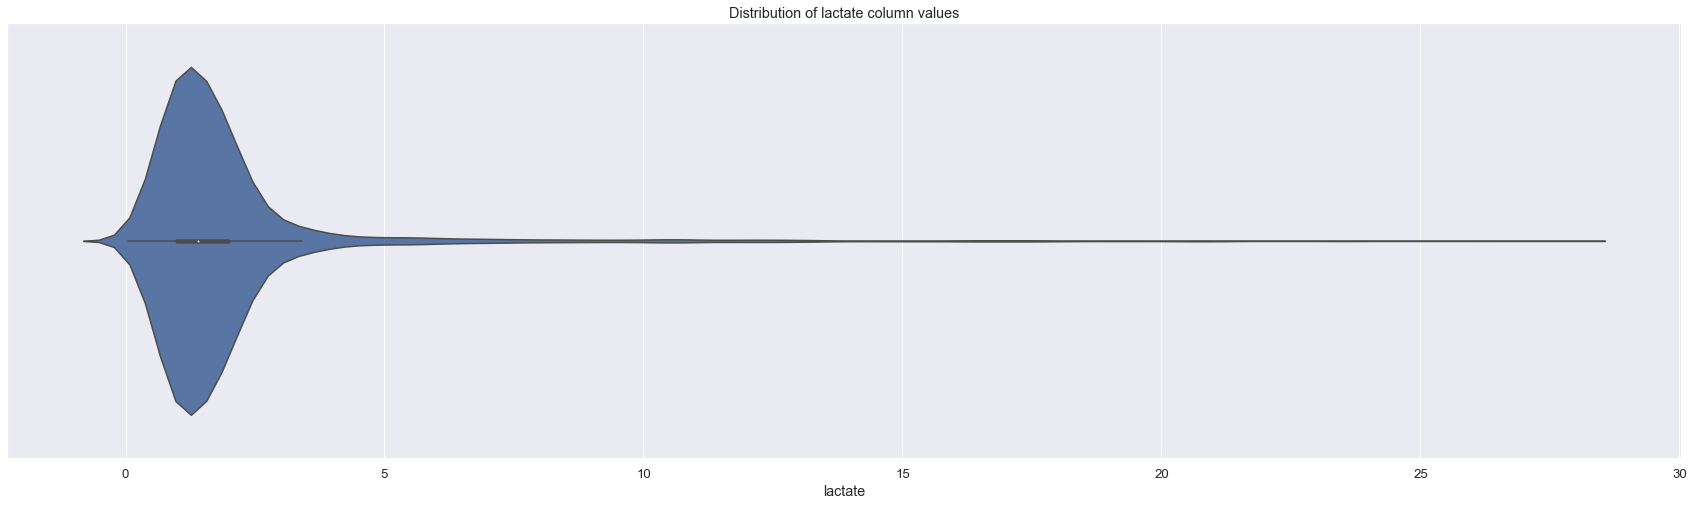

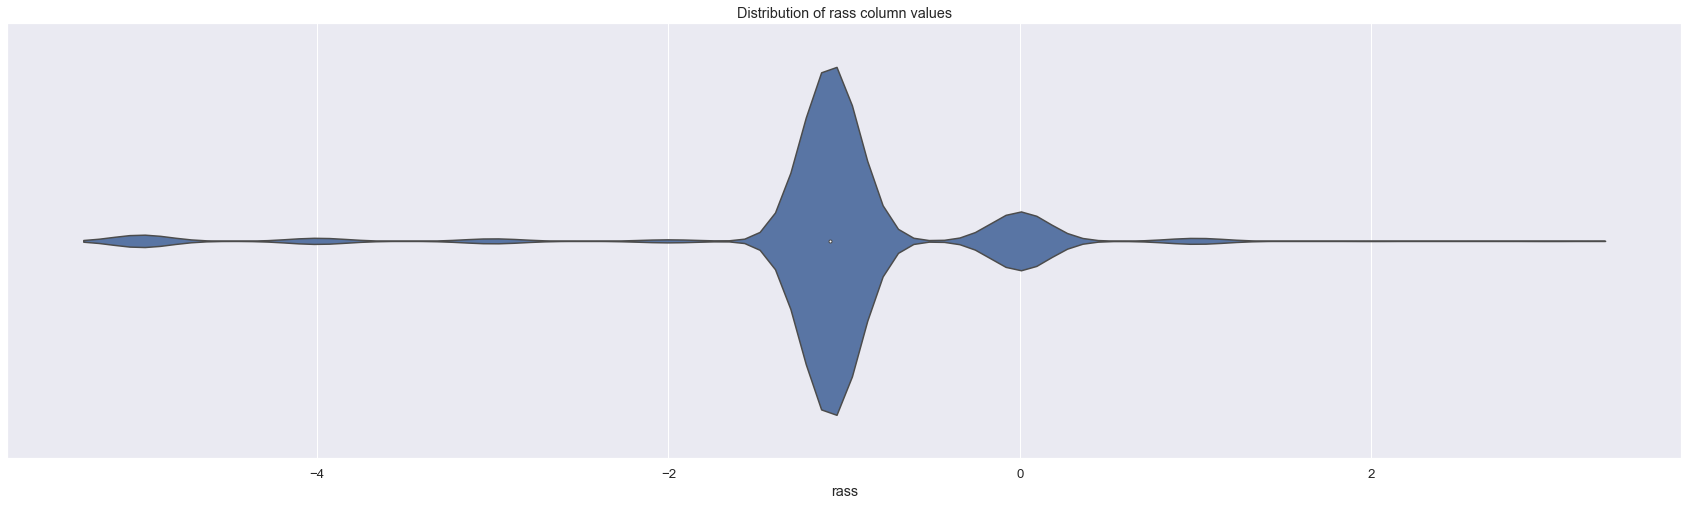

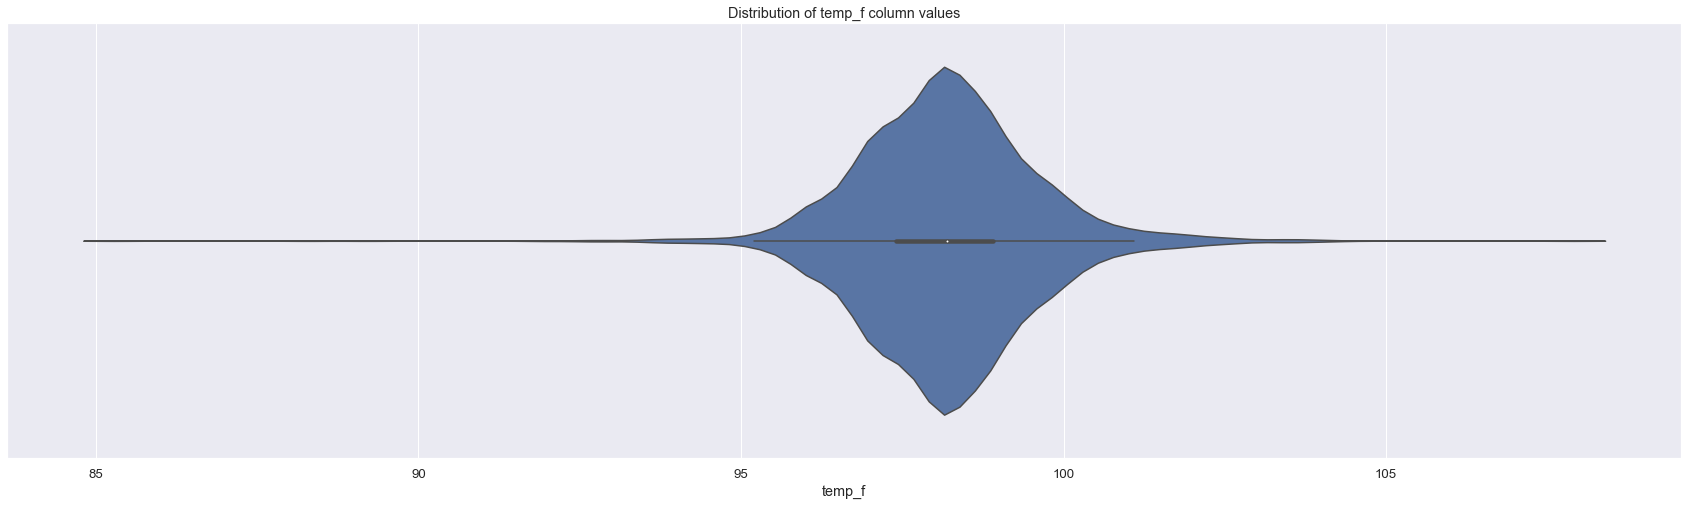

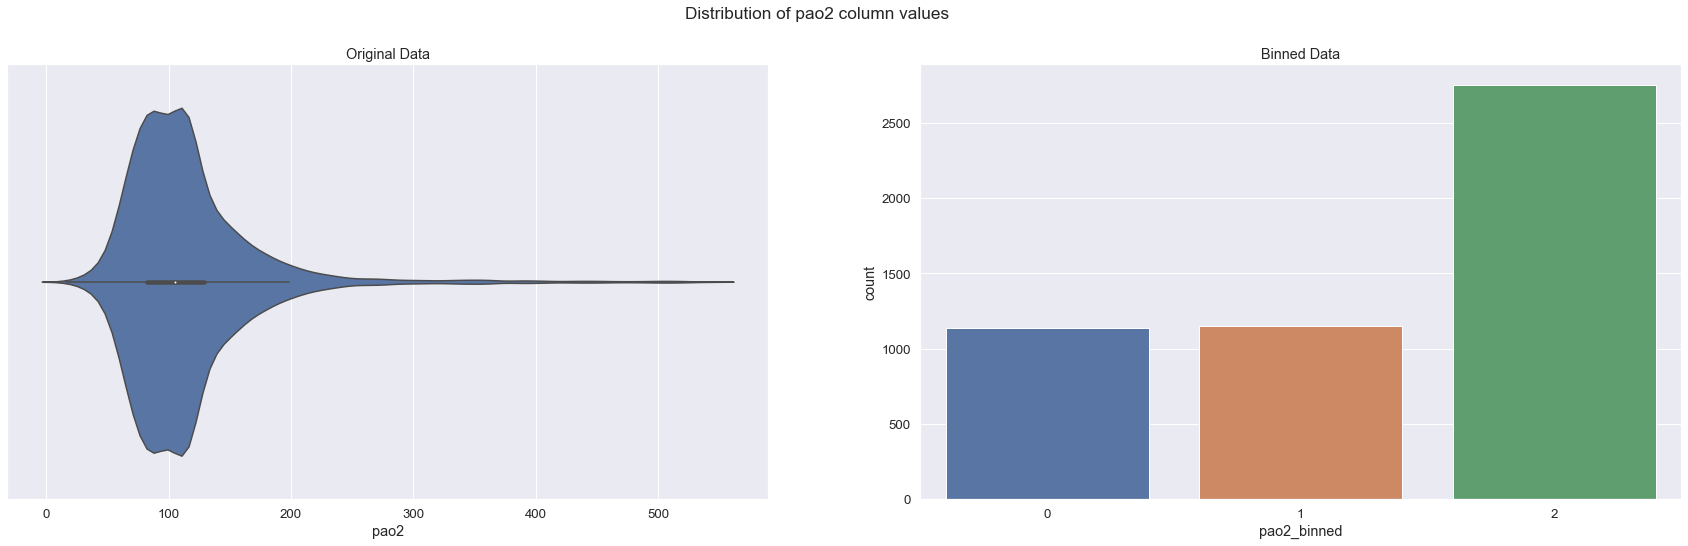

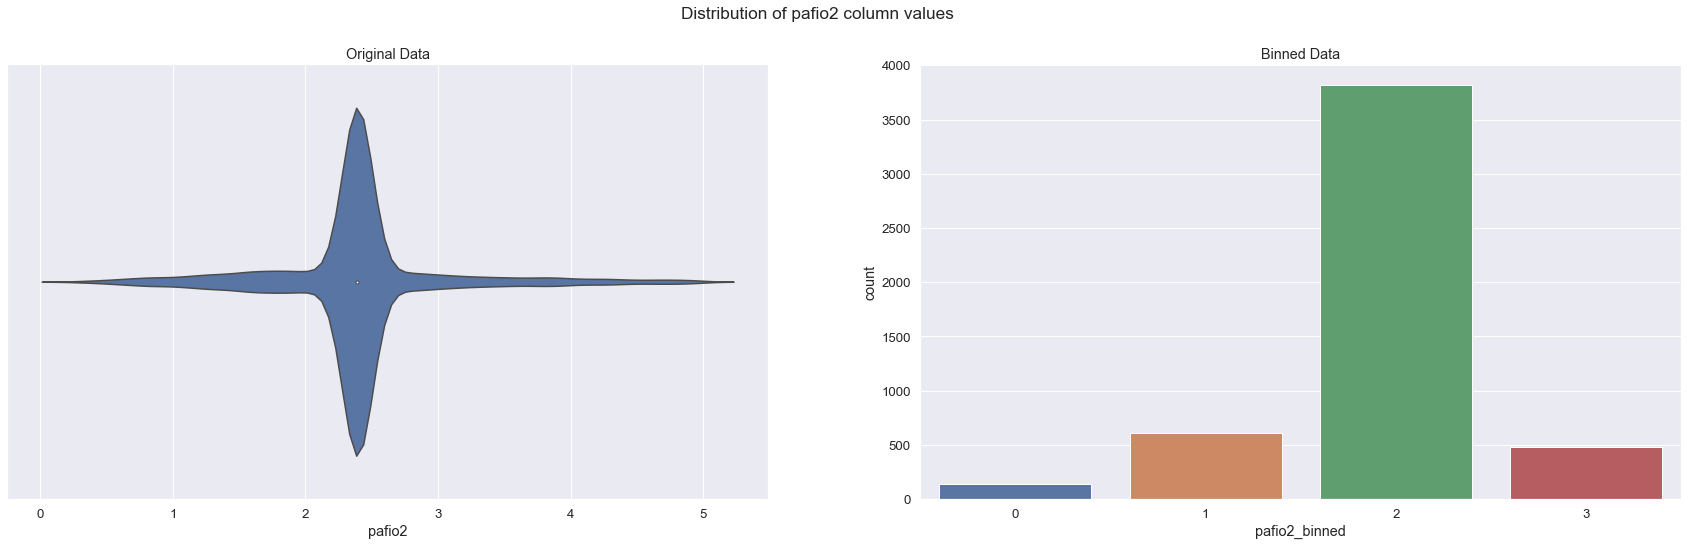

In [74]:
plot_feature_distributions(plot_type, mimic_data)

In [75]:
X_mimic = mimic_data.drop(columns=["id", "readmit"]+cols_binned+cols_numeric).astype("float")
X_mimic = X_mimic[feature_order]
y_mimic = mimic_data[["readmit"]]

In [89]:
X_mimic.describe()

,intub_days,female,ED_admit,COPD_hx,gcs,lactate,rass,temp_f,total_los_binned,icu_los_binned,age_binned,hct_binned,wbc_binned,inr_binned,cr_binned,pafio2_binned,pao2_binned,plt_binned,sao2_binned,hr_binned,map_binned,race_numeric
count,5043.000000,5043.000000,5043.000000,5043.000000,5043.00000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000
mean,8.161053,0.453302,0.512790,0.004957,11.73606,1.981905,-1.079181,98.189264,0.715249,0.593298,1.099544,0.882610,1.389451,0.828277,0.361689,1.918897,1.320048,0.850684,1.728931,0.940908,0.001190,6.889153
std,8.174633,0.497864,0.499886,0.070241,4.18376,2.379557,0.906361,1.363171,0.888364,0.829213,0.706690,0.326201,0.595021,0.742714,0.480537,0.564701,0.818208,0.589234,0.653682,0.591891,0.044519,2.161427
min,1.000000,0.000000,0.000000,0.000000,1.00000,0.050000,-5.000000,85.300003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,0.000000,0.000000,0.000000,10.00000,1.000000,-1.079181,97.400000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,2.000000,1.000000,0.000000,7.000000
50%,6.000000,0.000000,1.000000,0.000000,14.00000,1.400000,-1.079181,98.189264,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,2.000000,1.000000,2.000000,1.000000,0.000000,8.000000
75%,9.000000,1.000000,1.000000,0.000000,15.00000,1.981905,-1.079181,98.900002,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,0.000000,8.000000
max,102.000000,1.000000,1.000000,1.000000,15.00000,27.700000,3.000000,107.900002,3.000000,3.000000,2.000000,2.000000,2.000000,3.000000,1.000000,3.000000,2.000000,2.000000,2.000000,3.000000,2.000000,8.000000


## Test models on MIMIC dataset

Model accuracy: 0.909

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      4597
         1.0       0.33      0.03      0.05       446

    accuracy                           0.91      5043
   macro avg       0.62      0.51      0.50      5043
weighted avg       0.86      0.91      0.87      5043



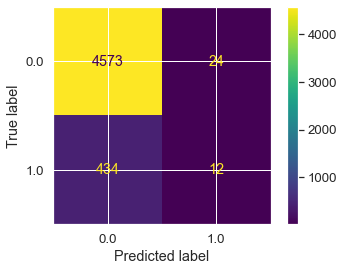

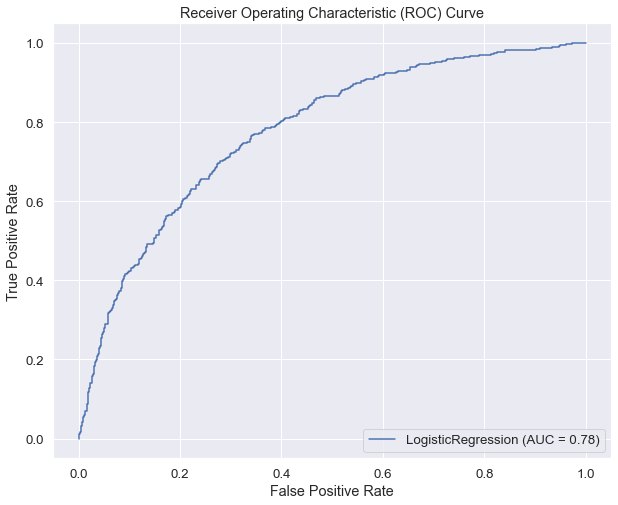

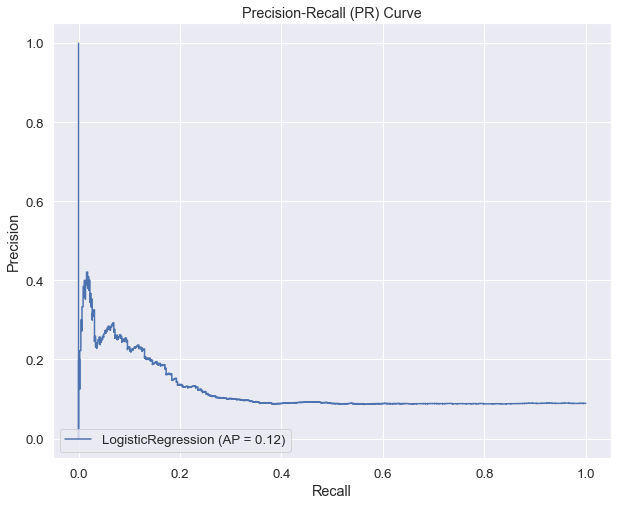

In [76]:
test_model(lr_best_model, X_mimic, y_mimic)

Model accuracy: 0.906

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      4597
         1.0       0.20      0.02      0.04       446

    accuracy                           0.91      5043
   macro avg       0.56      0.51      0.50      5043
weighted avg       0.85      0.91      0.87      5043



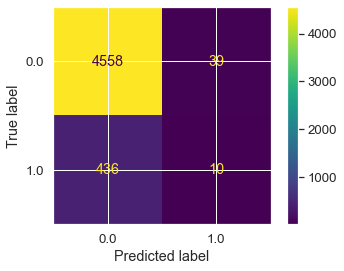

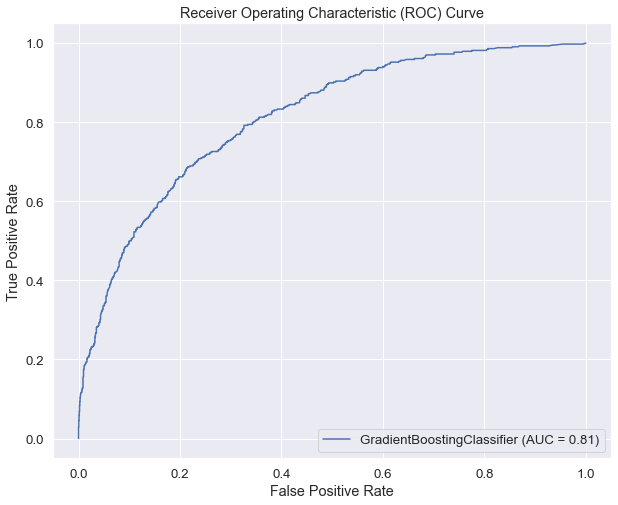

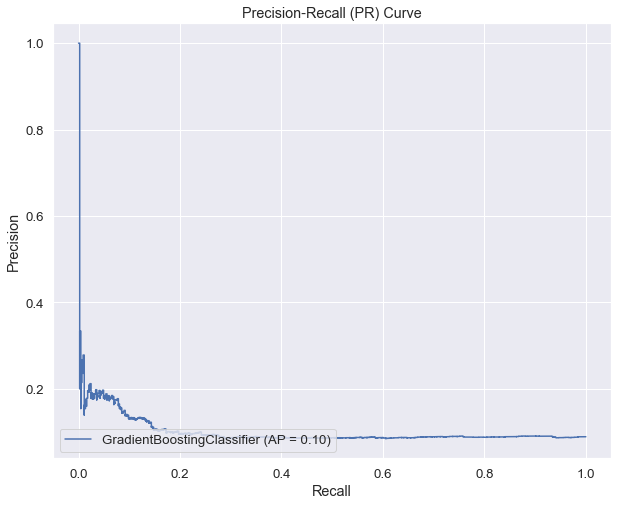

In [77]:
test_model(gb_best_model, X_mimic, y_mimic)